In [3]:
import sys
sys.path.append("../src")
import pandas as pd
from cv2 import imread
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from shapely import wkt
from matplotlib.ticker import FormatStrFormatter
from collections import defaultdict
from matplotlib.axes import Axes
from utils.common.pathManager import FilePath
from utils.visualization.label_to_color import LabelDict


In [4]:
seg_labels = ["background", "building"]
dmg_labels = ["background", "no-damage", "minor-damage", "major-damage", "destroyed"]
size = 24

def build_weights_table(out_path: FilePath) -> pd.DataFrame:
    w_json = out_path.join("conf_list.json")
    w_dict = w_json.read_json().get("0")
    dmg_w = w_dict.get("weights_dmg")
    seg_w = w_dict.get("weights_seg")
    w_row = [[cls_name, wei] for cls_name, wei in zip(seg_labels, seg_w)]
    w_row.extend([[cls_name, wei] for cls_name, wei in zip(dmg_labels, dmg_w)])
    return pd.DataFrame(w_row, columns=["Class", "Weight"])


def build_conf_table(out_path: FilePath):
    conf_dict: dict = out_path.join("conf_list.json").read_json()
    rows = []
    for i, param_dict in conf_dict.items():
        row = [f"Config {i}", param_dict["batch_size"], param_dict["learning_rate"], param_dict["hps_epochs"]]
        rows.append(row)
    return pd.DataFrame(rows, columns=["Number", "Batch size", "Learning rate", "Total epochs"])

def load_metric_dfs(split, metric_dir: FilePath) -> tuple[pd.DataFrame]:
    bld_df = pd.read_csv(metric_dir.join(f"{split}_bld_pixel_level.csv"))
    bld_df = bld_df.set_index(["epoch", "class"])
    dmg_df = pd.read_csv(metric_dir.join(f"{split}_dmg_pixel_level.csv"))
    dmg_df = dmg_df.set_index(["epoch", "class"])
    loss_df = pd.read_csv(metric_dir.join(f"{split}_loss.csv"))
    loss_df = loss_df.set_index(["epoch"])
    return bld_df, dmg_df, loss_df

def build_fold_table(out_path: FilePath):
    config_folders = [fol_name for fol_name in out_path.get_folder_names()
                      if fol_name.startswith("config")]
    fold_list = []
    for dir in config_folders:
        conf_path = out_path.join(dir)
        for fold in conf_path.get_folder_names():
            fold_dir = conf_path.join(fold)
            metric_dir = fold_dir.join("metrics/csv")
            bld_df, dmg_df, loss_df = load_metric_dfs("val", metric_dir)
            c = dir[len(dir)-1]
            f = fold[len(fold)-1]
            best_epoch = dmg_df["f1_harmonic_mean"].idxmax()[0]
            val_loss = loss_df.loc[best_epoch].iloc[0]
            seg_hf1 = bld_df.loc[best_epoch, 0]["f1_harmonic_mean"]
            dmg_hf1 = dmg_df.loc[best_epoch, 0]["f1_harmonic_mean"]
            row = [f"C{c}", f"F{f}", best_epoch, val_loss, dmg_hf1, seg_hf1]
            fold_list.append(row)

    fold_df = pd.DataFrame(fold_list, columns=["Conf", "Fold", "Best epoch", "val-loss", "HMf1-dmg", "HFM1-seg"])
    fold_df = fold_df.sort_values(by=["Conf"])
    fold_df = round(fold_df, 4)
    fold_df = fold_df.groupby("Conf").apply(lambda x: x.set_index("Fold"), include_groups=False)
    fold_df = fold_df.sort_values(["Conf", "Fold"])
    return fold_df

def build_subtable(split, best_epoch, bld_df, dmg_df, loss_df):
    # Segmentation sub sub table
    seg_sub = bld_df.loc[best_epoch,:].copy()
    seg_sub["hf1"] = bld_df.loc[best_epoch]["f1_harmonic_mean"].iloc[0].copy()
    seg_sub["hf1"] = round(seg_sub["hf1"],4)
    seg_sub.reset_index(inplace=True)
    seg_sub["class"] = seg_labels
    seg_sub.set_index("class", inplace=True)
    seg_sub = seg_sub.groupby(["hf1"]).apply(lambda x: x, include_groups=False)
    seg_sub.drop(columns=["f1_harmonic_mean"], inplace=True)

    # Classification sub sub table
    dmg_sub = dmg_df.loc[best_epoch, :].copy()
    dmg_sub["hf1"] = dmg_df.loc[best_epoch]["f1_harmonic_mean"].iloc[0].copy()
    dmg_sub["hf1"] = round(dmg_sub["hf1"],4)
    dmg_sub.reset_index(inplace=True)
    dmg_sub["class"] = dmg_labels
    dmg_sub.set_index("class", inplace=True)
    dmg_sub = dmg_sub.groupby(["hf1"]).apply(lambda x: x, include_groups=False)
    dmg_sub.drop(columns=["f1_harmonic_mean"], inplace=True)

    subtable = pd.concat([seg_sub, dmg_sub])
    subtable["split"] = split
    subtable = subtable.groupby(["split"]).apply(lambda x: x, include_groups=False)
    subtable = round(subtable, 4)
    loss = loss_df.loc[best_epoch].iloc[0]
    loss = round(loss, 4)
    return subtable, loss


def build_val_test_table(path: FilePath, fold_df: pd.DataFrame, test=False):
    metric_dir = path.join("final_model/metrics/csv/")
    val_bld_df, val_dmg_df, val_loss_df = load_metric_dfs('val', metric_dir)
    test_bld_df, test_dmg_df, test_loss_df = load_metric_dfs('test', metric_dir)

    best_conf = fold_df["HMf1-dmg"].idxmax() if len(fold_df > 0) else 0
    best_epoch = test_dmg_df.index[0][0]
    val_sub, val_loss = build_subtable("validation", best_epoch, val_bld_df, val_dmg_df, val_loss_df)

    header = f"Mejor Configuración: {best_conf} \\quad Mejor época: {best_epoch} \\quad \\emph{{val\\_loss}} = {val_loss}"
    if (test):
        test_sub, test_loss = build_subtable("test", best_epoch, test_bld_df, test_dmg_df, test_loss_df)
        table = pd.concat([val_sub, test_sub])
        header += f" \\quad \\emph{{test\\_loss}} = {test_loss}" 
    else:
        table = val_sub
    return header, table

import locale
locale.setlocale(locale.LC_ALL, 'es_ES.UTF-8')

def comma_formatter(ax:Axes, digits:int):
    #ax.set_xticks([tick for tick in plt.xticks()[0]], [
    #       str(tick).replace('.', ',') for tick in plt.xticks()[0]])
    ax.set_yticks([tick for tick in plt.yticks()[0]], [
           locale.format_string(f'%.{digits}f', tick) for tick in plt.yticks()[0]])
    
def plot_loss(tr_l: pd.DataFrame, vl_l: pd.DataFrame, step):
    # Renombrar las columnas para evitar confusiones
    tr_l = tr_l.rename(columns={"loss": "train_loss"})
    vl_l = vl_l.rename(columns={"loss": "val_loss"})
    f_df = pd.concat([tr_l, vl_l], axis=1)

    # Crear la figura y el eje, ajustando el tamaño
    fig, ax = plt.subplots(figsize=(12, 5), dpi=500)

    # Graficar las pérdidas de entrenamiento y validación
    ax.plot(f_df.index, f_df["train_loss"], label="Pérdida en Entrenamiento", linewidth=3, color="#65a6cc")
    ax.plot(f_df.index, f_df["val_loss"], label="Pérdida en Validación", linestyle='--', linewidth=3, color='#abc56a')

    # Título y etiquetas con fuentes más grandes
    ax.set_xlabel('Época', fontsize=size)
    ax.set_ylabel('Función de pérdida', fontsize=size)

    # Aumentar el tamaño de la leyenda
    fig.subplots_adjust(left=-0.4, right=0.4) 
    ax.legend(fontsize=size, fancybox=True, framealpha=1, shadow=True, borderpad=1,
            loc="upper center", ncol=2, bbox_to_anchor=(0.43, 1.35))
    
    ax.set_xticks(range(0, f_df.index.max()+1, step))

    # Añadir cuadrícula
    comma_formatter(ax,3)
    ax.grid(True)
    ax.tick_params(axis='both', which='major', labelsize=size)
    plt.show()


def plot_harmonic_mean(tr_m: pd.DataFrame, vl_m: pd.DataFrame, step):
    # Filtrar y procesar los datos de entrenamiento y validación para la clase 0
    tr = tr_m[tr_m["class"] == 0][["epoch", "f1_harmonic_mean"]]
    tr = tr.rename(columns={"f1_harmonic_mean": "f1_h_train"})
    tr = tr.set_index("epoch")

    vl = vl_m[vl_m["class"] == 0][["epoch", "f1_harmonic_mean"]]
    vl = vl.rename(columns={"f1_harmonic_mean": "f1_h_val"})
    vl = vl.set_index("epoch")

    # Concatenar los datos de entrenamiento y validación
    metrics_df = pd.concat([tr, vl], axis=1)

    # Crear la figura y el eje
    fig, ax = plt.subplots(figsize=(12, 5), dpi=500)

    # Graficar cada conjunto de datos por separado
    ax.plot(metrics_df.index, metrics_df['f1_h_train'],
            label='HMF1 de Entrenamiento', color='#65a6cc', linewidth=3)
    ax.plot(metrics_df.index, metrics_df['f1_h_val'],
            label='HMF1 de Validación', color='#abc56a', linestyle='--', linewidth=3)

    # Configuración de título y etiquetas en español
    # ax.set_title('Media Armónica del F1 a lo largo de las Épocas', fontsize=18)
    ax.set_xlabel('Época', fontsize=size)
    ax.set_ylabel('Métrica HMF1', fontsize=size)

    # Asegurar que el eje X use números enteros
    ax.set_xticks(range(0, tr_m["epoch"].max()+1, step))

    # Aumentar el tamaño de la leyenda y configurarla adecuadamente
    fig.subplots_adjust(left=-0.38, right=0.38) 
    ax.legend(fontsize=size, fancybox=True, framealpha=1, shadow=True, borderpad=1,
            loc="upper center", ncol=2, bbox_to_anchor=(0.435, 1.35))
    
    comma_formatter(ax,1)
    # Aumentar el tamaño de las marcas en los ejes
    ax.tick_params(axis='both', which='major', labelsize=size)

    # Mostrar cuadrícula
    ax.grid(True)

    # Mostrar la gráfica
    plt.show()


def plot_metric_per_class(tr_m: pd.DataFrame, metric: str, step, loc='best'):
    thisSize = size+15
    # Convertir números de clase en nombres de clase
    tr_m['class'] = tr_m['class'].apply(lambda x: LabelDict().get_key_by_num(int(x)))

    # Pivotar los datos para tener épocas como índice y clases como columnas
    tr = tr_m.pivot(index='epoch', columns='class', values=metric)

    # puedes personalizar estos colores
    colors = ['#0f0f0f', '#ff1e1e', '#2ca02c', '#ffa500', '#808080']

    # Crear la figura y el eje con un DPI mejorado para mayor calidad
    fig, ax = plt.subplots(figsize=(10, 8), dpi=500)

    # Graficar cada clase con un color y estilo de línea diferente
    for i, col in enumerate(tr.columns):
        ax.plot(tr.index, tr[col], label=f"{col}", linewidth=3, color=colors[i % len(colors)])

    # Configuración de título y etiquetas en español
    ax.set_xlabel('Época', fontsize=thisSize)
    ax.set_ylabel(f'{metric.capitalize()}', fontsize=thisSize)

    # Configuración de la leyenda
    fig.subplots_adjust(left=-0.8, right=0.8)
    ax:Axes
    ax.legend(fontsize=thisSize, fancybox=True, framealpha=1, shadow=True, borderpad=1,
            loc="upper center", ncol=3, bbox_to_anchor=(0.46, 1.5))

    # Asegurar que el eje X use números enteros
    ax.set_xticks(range(0, tr_m["epoch"].max()+1, step))

    comma_formatter(ax,1)
    # Aumentar el tamaño de las marcas en los ejes
    ax.tick_params(axis='both', which='major', labelsize=thisSize)

    # Mostrar cuadrícula
    ax.grid(True)

    # Mostrar la gráfica
    #plt.tight_layout()  # Ajustar automáticamente el diseño para que no se solapen elementos
    plt.show()

def plot_lr(lr_df):
    # Redondear y renombrar columnas
    lr_df = lr_df[["Step", "Value"]].round(8)
    lr_df.columns = ["Epoch", "LR"]

    # Configurar el índice
    lr_df.set_index("Epoch", inplace=True)

    # Crear la figura y el eje con un DPI mejorado para mayor calidad
    fig, ax = plt.subplots(figsize=(10, 6), dpi=500)

    # Graficar la tasa de aprendizaje
    ax.plot(lr_df.index, lr_df["LR"], linewidth=3, color='gray')

    # Configuración de título y etiquetas en español
    ax.set_xlabel('Época', fontsize=size)
    ax.set_ylabel('Tasa de Aprendizaje (LR)', fontsize=size)

    # Asegurar que el eje X use números enteros
    ax.set_xticks(range(0, lr_df.index.max() + 1, 20))
    ax.tick_params(axis='both', which='major', labelsize=size)

    # Usar escala logarítmica en el eje Y
    ax.set_yscale('log')

    # Mostrar cuadrícula
    ax.grid(True)

    # Ajustar automáticamente el diseño para que no se solapen elementos
    plt.tight_layout()

    # Mostrar la gráfica
    plt.show()


def read_multi_csv(p):
    mult_df = pd.read_csv(p)
    labels = ["Background","No Damage", "Minor Damage", "Major Damage", "Destroyed","Total"]  
    mult_df.index = labels
    mult_df.columns = labels
    return mult_df

def get_bld_px_multi(mult_df):
    building_col = mult_df[["No Damage","Minor Damage","Major Damage","Destroyed"]].sum(axis=1)
    background = mult_df[["Background"]]
    bld_pixel_df = pd.concat([background,building_col],axis=1) 
    bld_pixel_df.columns = ["Background","Building"]
    building_row = bld_pixel_df.iloc[1:-1].sum(axis=0).to_frame().transpose()
    building_row.index = ["Building"]
    bld_pixel_df.iloc[[0]]
    bld_pixel_df = pd.concat([bld_pixel_df.iloc[[0]],building_row],axis=0)
    bld_pixel_df["Total"] = bld_pixel_df.sum(axis=1) 
    bld_pixel_df.loc["Total"] = bld_pixel_df.sum(axis=0)
    return bld_pixel_df

def get_percentual_px_multi(df):
    df_percentage = df.copy()
    for col in df.columns[:-1]:
        df_percentage[col] = df[col] / df["Total"]
    df_percentage["Total%"] = df_percentage["Total"] / df_percentage["Total"].iloc[-1] 
    return round(df_percentage,2)

def get_dmg_px_multi(mult_df):
    dmg_df = mult_df.copy()
    dmg_df["Total"] = mult_df.loc[:,"Total"] - mult_df.loc[:,"Background"]
    dmg_df = dmg_df.drop("Background",axis=1)
    dmg_df.loc["Total"] = dmg_df.loc["Total",:] - dmg_df.loc["Background",:]
    dmg_df = dmg_df.drop("Background",axis=0)
    return dmg_df

def get_obj_mtrx(p):
    obj_df = pd.read_csv(p)
    obj_df = obj_df.drop("5",axis=1)
    obj_df = obj_df.drop(index=4)
    obj_df = obj_df.iloc[[0,1,2,3,5,4], [0,1,2,3,5,4]]
    obj_df.columns=["No Damage", "Minor Damage", "Major Damage", "Destroyed", "Undetected","Total"]
    obj_df.index=["No Damage", "Minor Damage", "Major Damage", "Destroyed", "Ghost","Total"]
    obj_df.loc["Total","Total"] = 0
    obj_df.loc["Ghost","Undetected"] = 0
    obj_df.loc["Ghost","Total"] = obj_df.loc[:,"Total"][:4].sum()
    obj_df.loc["Total","Undetected"] = obj_df.loc["Total",:][:4].sum()
    return obj_df

def get_obj_metrics(p):
    obj_metrics_df = pd.read_csv(p)
    obj_metrics_df = obj_metrics_df.drop(4,axis=0)
    obj_metrics_df["f1_harmonic_mean"] = 4 / (1 / obj_metrics_df["f1"]).sum()
    obj_metrics_df = round(obj_metrics_df,4)
    obj_metrics_df.groupby("f1_harmonic_mean").apply(lambda x: x,include_groups=False)
    return obj_metrics_df

# Experiment 1

In [5]:
path = FilePath("/home/mrtc101/Desktop/tesina/repo/prev_outs/exp6/out")

In [6]:
wei_df = build_weights_table(path)
wei_df

Class   Weight
0    background     1.92
1      building     2.08
2    background     1.92
3     no-damage     2.22
4  minor-damage    43.99
5  major-damage   160.10
6     destroyed  2407.35

In [7]:
print(wei_df.to_latex(index=False,float_format="%.2f"))

\begin{tabular}{lr}
\toprule
Class & Weight \\
\midrule
background & 1.92 \\
building & 2.08 \\
background & 1.92 \\
no-damage & 2.22 \\
minor-damage & 43.99 \\
major-damage & 160.10 \\
destroyed & 2407.35 \\
\bottomrule
\end{tabular}



In [8]:
params_df = build_conf_table(path)
params_df

Number  Batch size  Learning rate  Total epochs
0  Config 0          16         0.0010           100
1  Config 1          16         0.0001           100
2  Config 2          32         0.0010           100
3  Config 3          32         0.0001           100
4  Config 4          64         0.0010           100
5  Config 5          64         0.0001           100

In [9]:
print(params_df.to_latex(index=False,float_format="%.4f"))

\begin{tabular}{lrrr}
\toprule
Number & Batch size & Learning rate & Total epochs \\
\midrule
Config 0 & 16 & 0.0010 & 100 \\
Config 1 & 16 & 0.0001 & 100 \\
Config 2 & 32 & 0.0010 & 100 \\
Config 3 & 32 & 0.0001 & 100 \\
Config 4 & 64 & 0.0010 & 100 \\
Config 5 & 64 & 0.0001 & 100 \\
\bottomrule
\end{tabular}



In [10]:
fold_df = build_fold_table(path)
fold_df

Best epoch  val-loss  HMf1-dmg  HFM1-seg
Conf Fold                                          
C0   F0            42    0.1257    0.0000    0.8612
     F1            56    0.1329    0.0000    0.8506
     F2            99    0.1446    0.0158    0.8504
     F3            41    0.1269    0.0000    0.8630
     F4            71    0.1350    0.0000    0.8638
C1   F0            43    0.1330    0.0000    0.8446
     F1            11    0.1423    0.0037    0.8391
     F2             5    0.1402    0.0004    0.8255
     F3             6    0.1416    0.0000    0.7750
     F4             6    0.1463    0.0000    0.7914
C2   F0            78    0.0695    0.0000    0.8646
     F1            14    0.0698    0.0010    0.8268
     F2            44    0.0680    0.0000    0.8547
     F3            28    0.0673    0.0000    0.8442
     F4            91    0.0690    0.0000    0.8545
C3   F0             1    0.0808    0.0005    0.7774
     F1            48    0.0719    0.0028    0.8295
     F2            54    0.0699    0.0000    0.8180
     F3            72    0.0713    0.0000    0.8192
     F4            19    0.0739    0.0000    0.8464
C4   F0            99    0.0371    0.0049    0.8509
     F1            80    0.0342    0.0000    0.8504
     F2            55    0.0346    0.0000    0.8576
     F3             2    0.0377    0.0000    0.8011
     F4             1    0.0424    0.0001    0.7132
C5   F0            88    0.0376    0.0036    0.8098
     F1            78    0.0372    0.0000    0.8033
     F2            26    0.0366    0.0000    0.8353
     F3            64    0.0372    0.0000    0.8272
     F4            10    0.0377    0.0000    0.7892

In [11]:
print(fold_df.to_latex(index=True,float_format="%.4f"))


\begin{tabular}{llrrrr}
\toprule
 &  & Best epoch & val-loss & HMf1-dmg & HFM1-seg \\
Conf & Fold &  &  &  &  \\
\midrule
\multirow[t]{5}{*}{C0} & F0 & 42 & 0.1257 & 0.0000 & 0.8612 \\
 & F1 & 56 & 0.1329 & 0.0000 & 0.8506 \\
 & F2 & 99 & 0.1446 & 0.0158 & 0.8504 \\
 & F3 & 41 & 0.1269 & 0.0000 & 0.8630 \\
 & F4 & 71 & 0.1350 & 0.0000 & 0.8638 \\
\cline{1-6}
\multirow[t]{5}{*}{C1} & F0 & 43 & 0.1330 & 0.0000 & 0.8446 \\
 & F1 & 11 & 0.1423 & 0.0037 & 0.8391 \\
 & F2 & 5 & 0.1402 & 0.0004 & 0.8255 \\
 & F3 & 6 & 0.1416 & 0.0000 & 0.7750 \\
 & F4 & 6 & 0.1463 & 0.0000 & 0.7914 \\
\cline{1-6}
\multirow[t]{5}{*}{C2} & F0 & 78 & 0.0695 & 0.0000 & 0.8646 \\
 & F1 & 14 & 0.0698 & 0.0010 & 0.8268 \\
 & F2 & 44 & 0.0680 & 0.0000 & 0.8547 \\
 & F3 & 28 & 0.0673 & 0.0000 & 0.8442 \\
 & F4 & 91 & 0.0690 & 0.0000 & 0.8545 \\
\cline{1-6}
\multirow[t]{5}{*}{C3} & F0 & 1 & 0.0808 & 0.0005 & 0.7774 \\
 & F1 & 48 & 0.0719 & 0.0028 & 0.8295 \\
 & F2 & 54 & 0.0699 & 0.0000 & 0.8180 \\
 & F3 & 72 & 0.0713 

In [12]:
header, table = build_val_test_table(path, fold_df)
print(header)
print(table.to_latex(index=True,float_format="%.4f"))

Mejor Configuración: ('C0', 'F2') \quad Mejor época: 98 \quad \emph{val\_loss} = 0.1278
\begin{tabular}{lllrrrr}
\toprule
 &  &  & precision & recall & f1 & accuracy \\
split & hf1 & class &  &  &  &  \\
\midrule
\multirow[t]{7}{*}{validation} & \multirow[t]{2}{*}{0.775400} & background & 0.9298 & 0.9517 & 0.9406 & 0.8989 \\
 &  & building & 0.7066 & 0.6183 & 0.6595 & 0.8989 \\
\cline{2-7}
 & \multirow[t]{5}{*}{0.000000} & background & 0.9301 & 0.9515 & 0.9407 & 0.8989 \\
 &  & no-damage & 0.7046 & 0.6158 & 0.6572 & 0.8993 \\
 &  & minor-damage & 0.0000 & 0.0000 & 0.0000 & 0.9992 \\
 &  & major-damage & 0.0000 & 0.0000 & 0.0000 & 0.9988 \\
 &  & destroyed & 0.0000 & 0.0000 & 0.0000 & 1.0000 \\
\cline{1-7} \cline{2-7}
\bottomrule
\end{tabular}



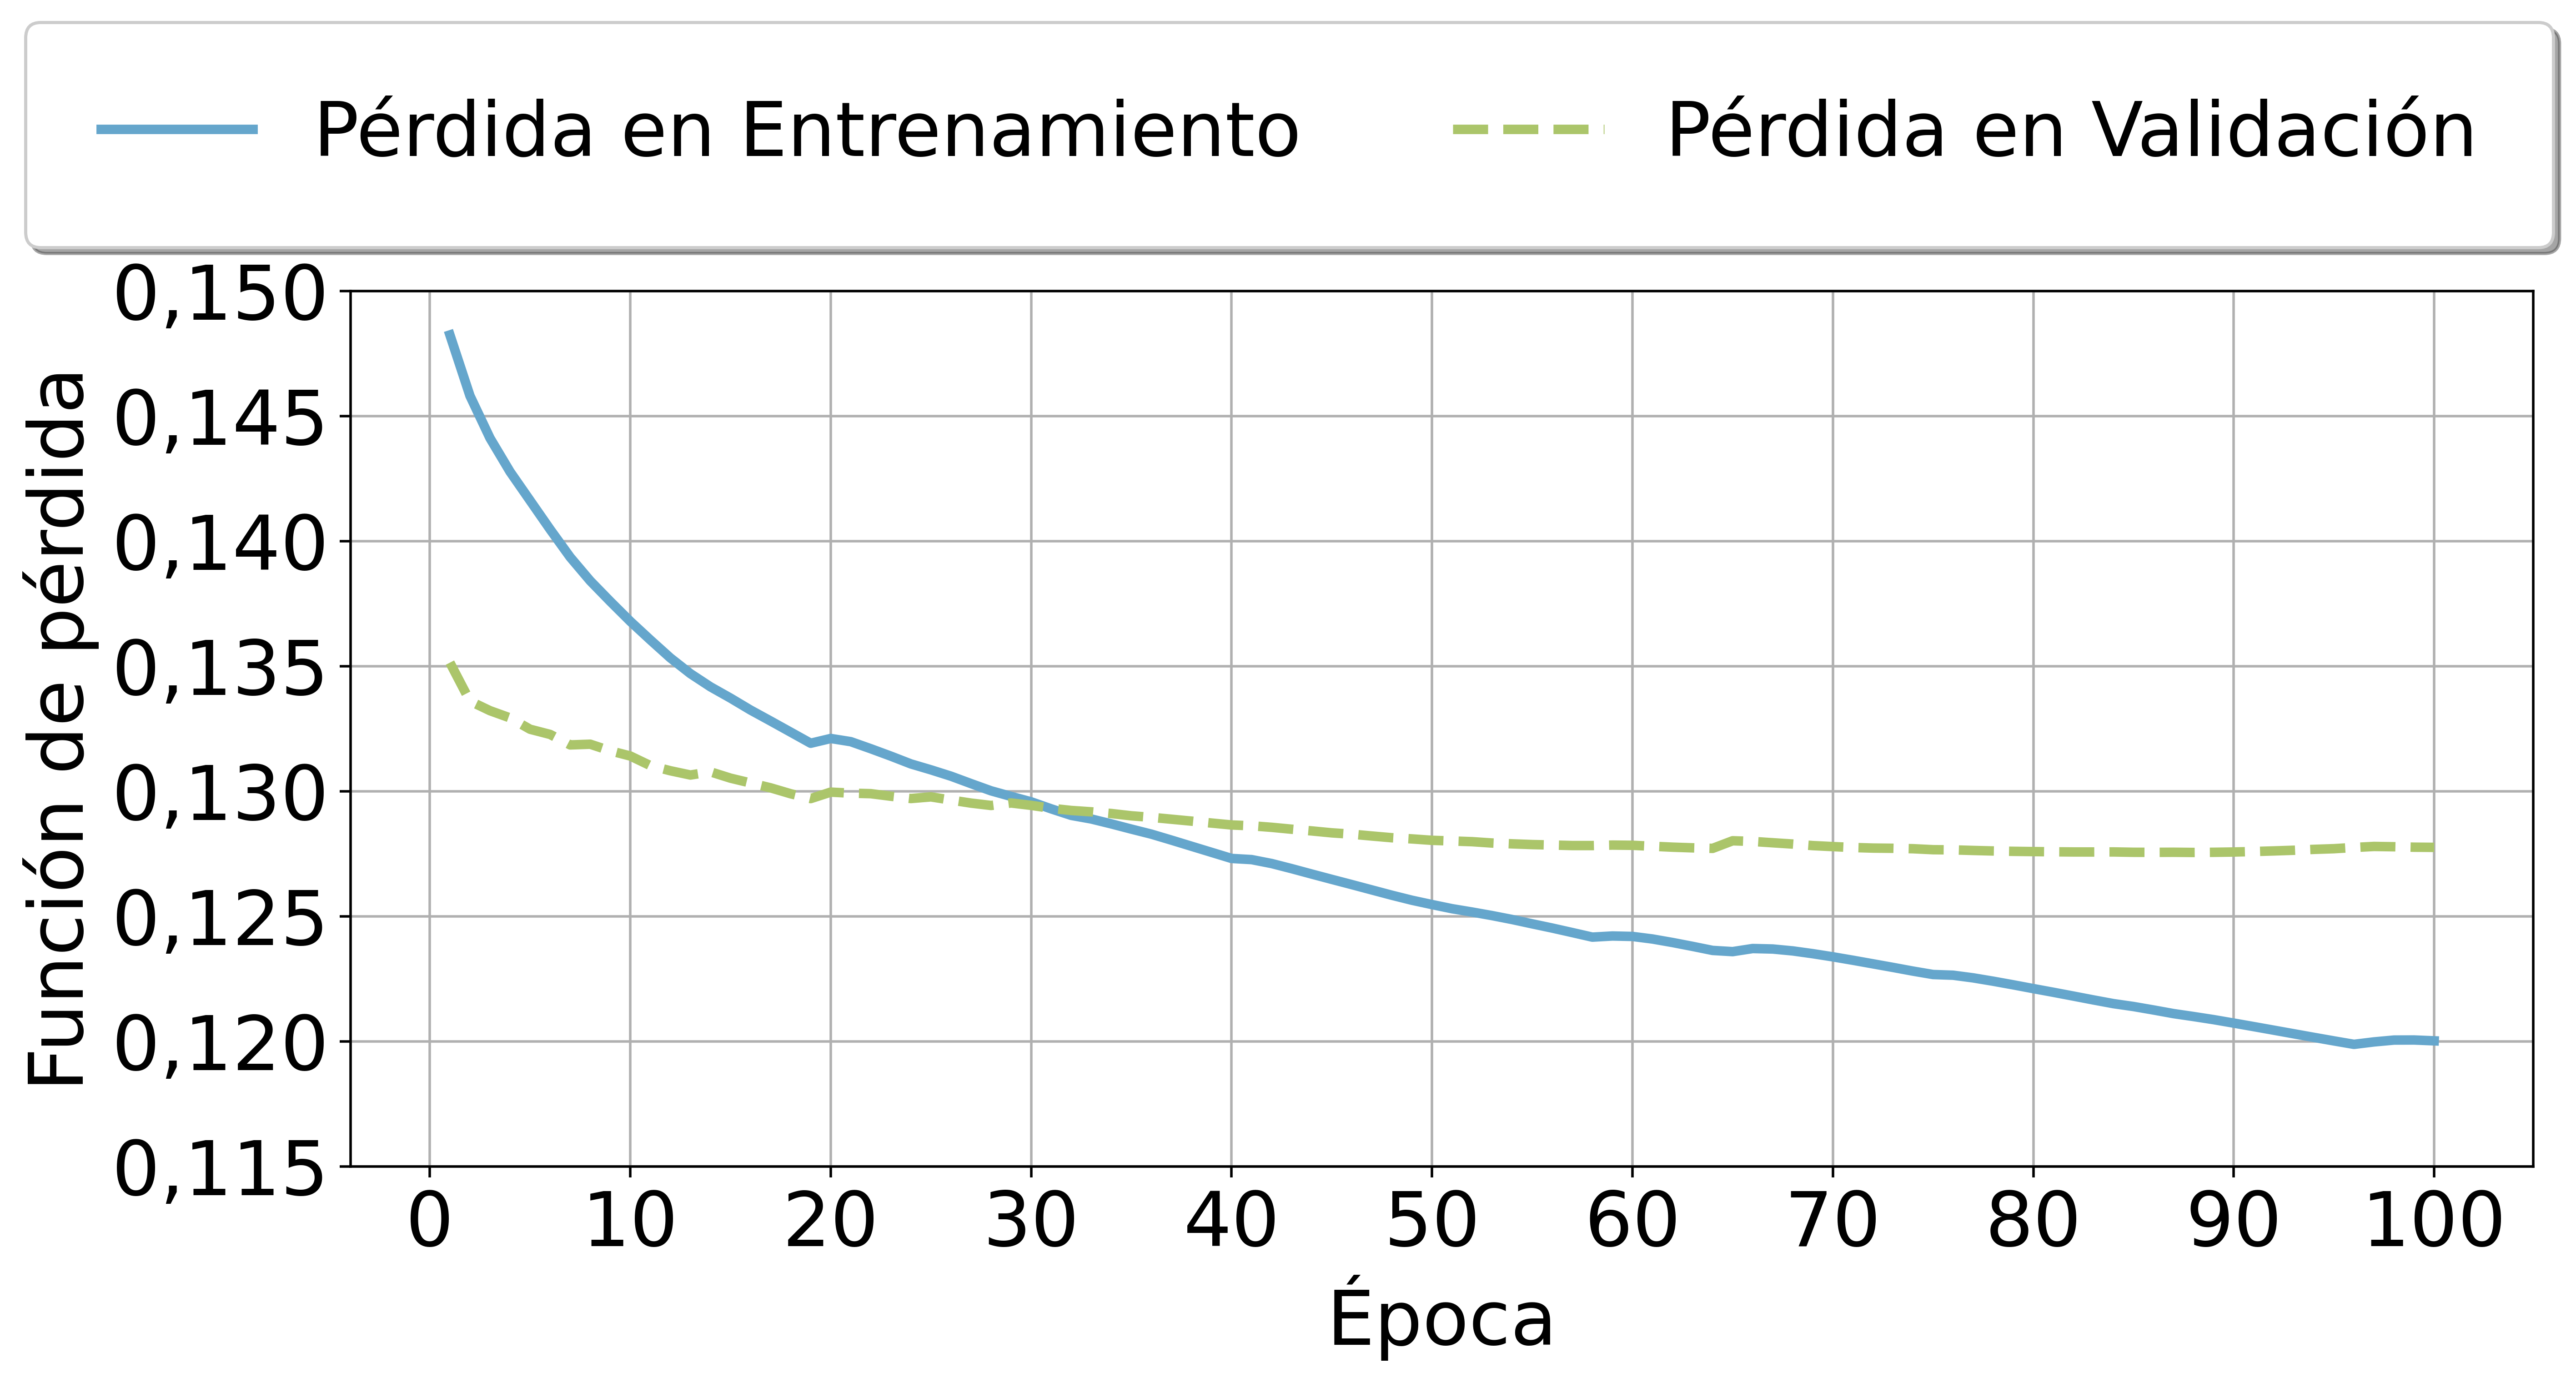

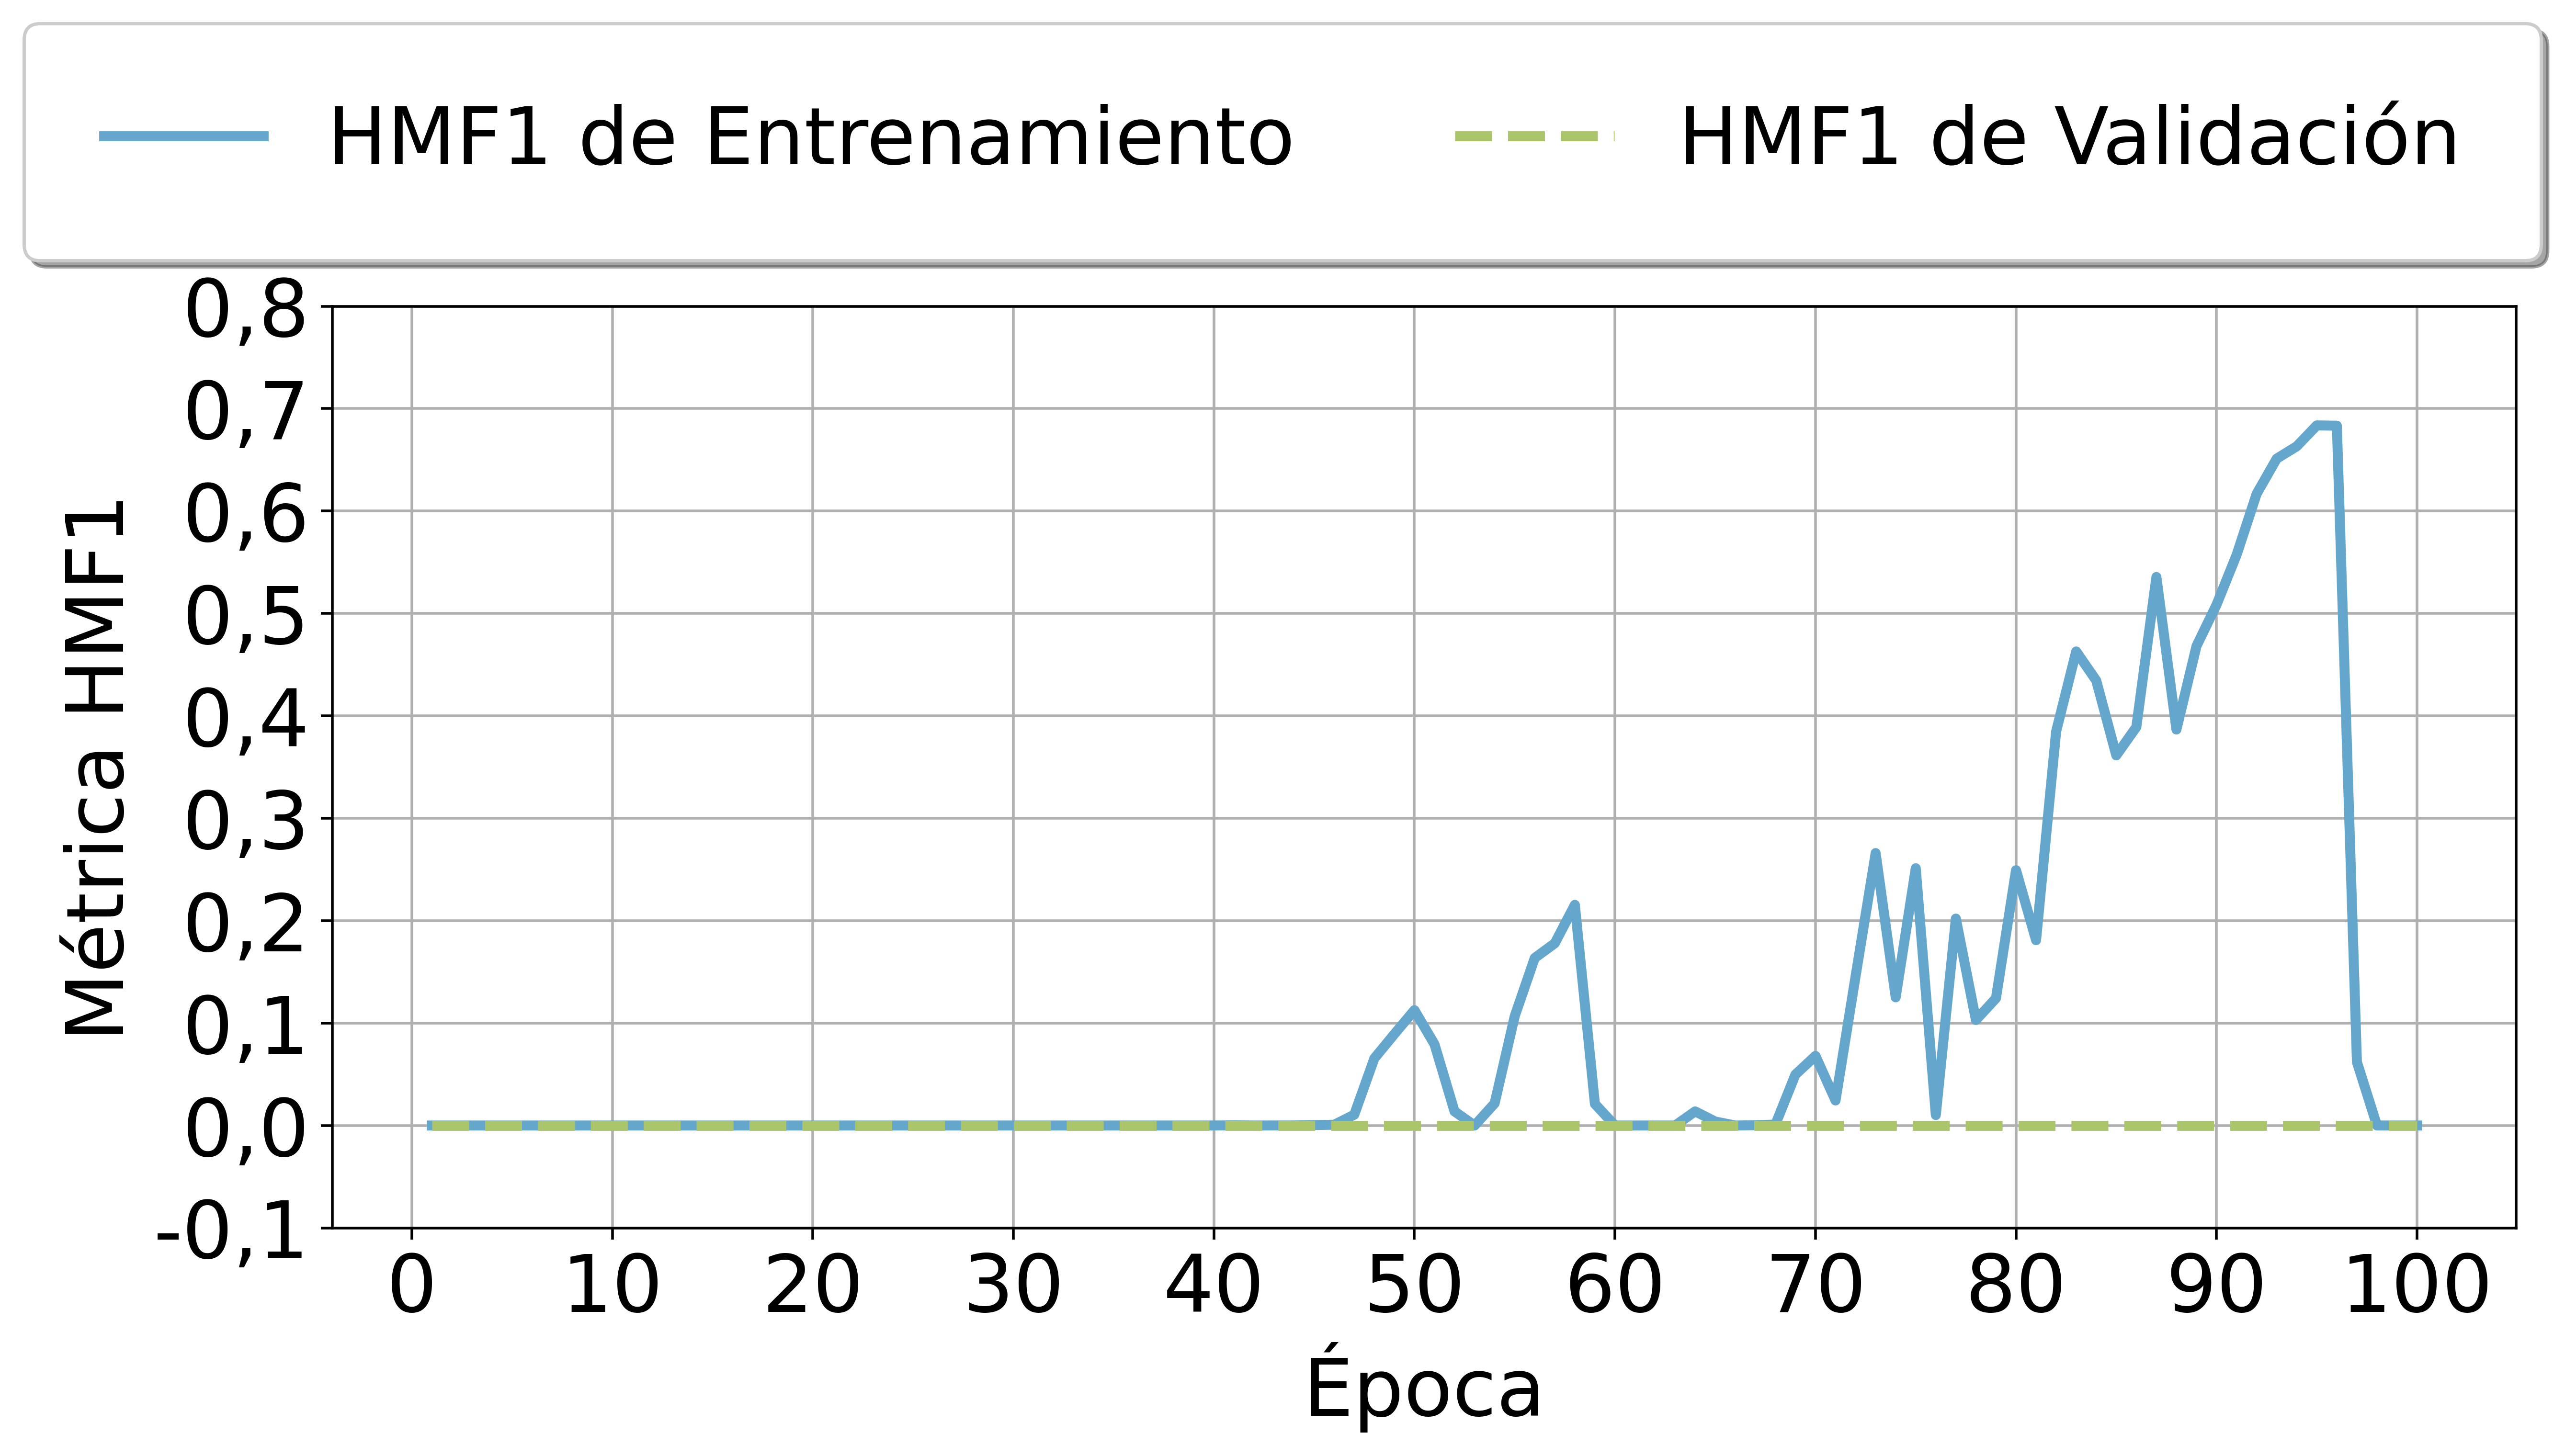

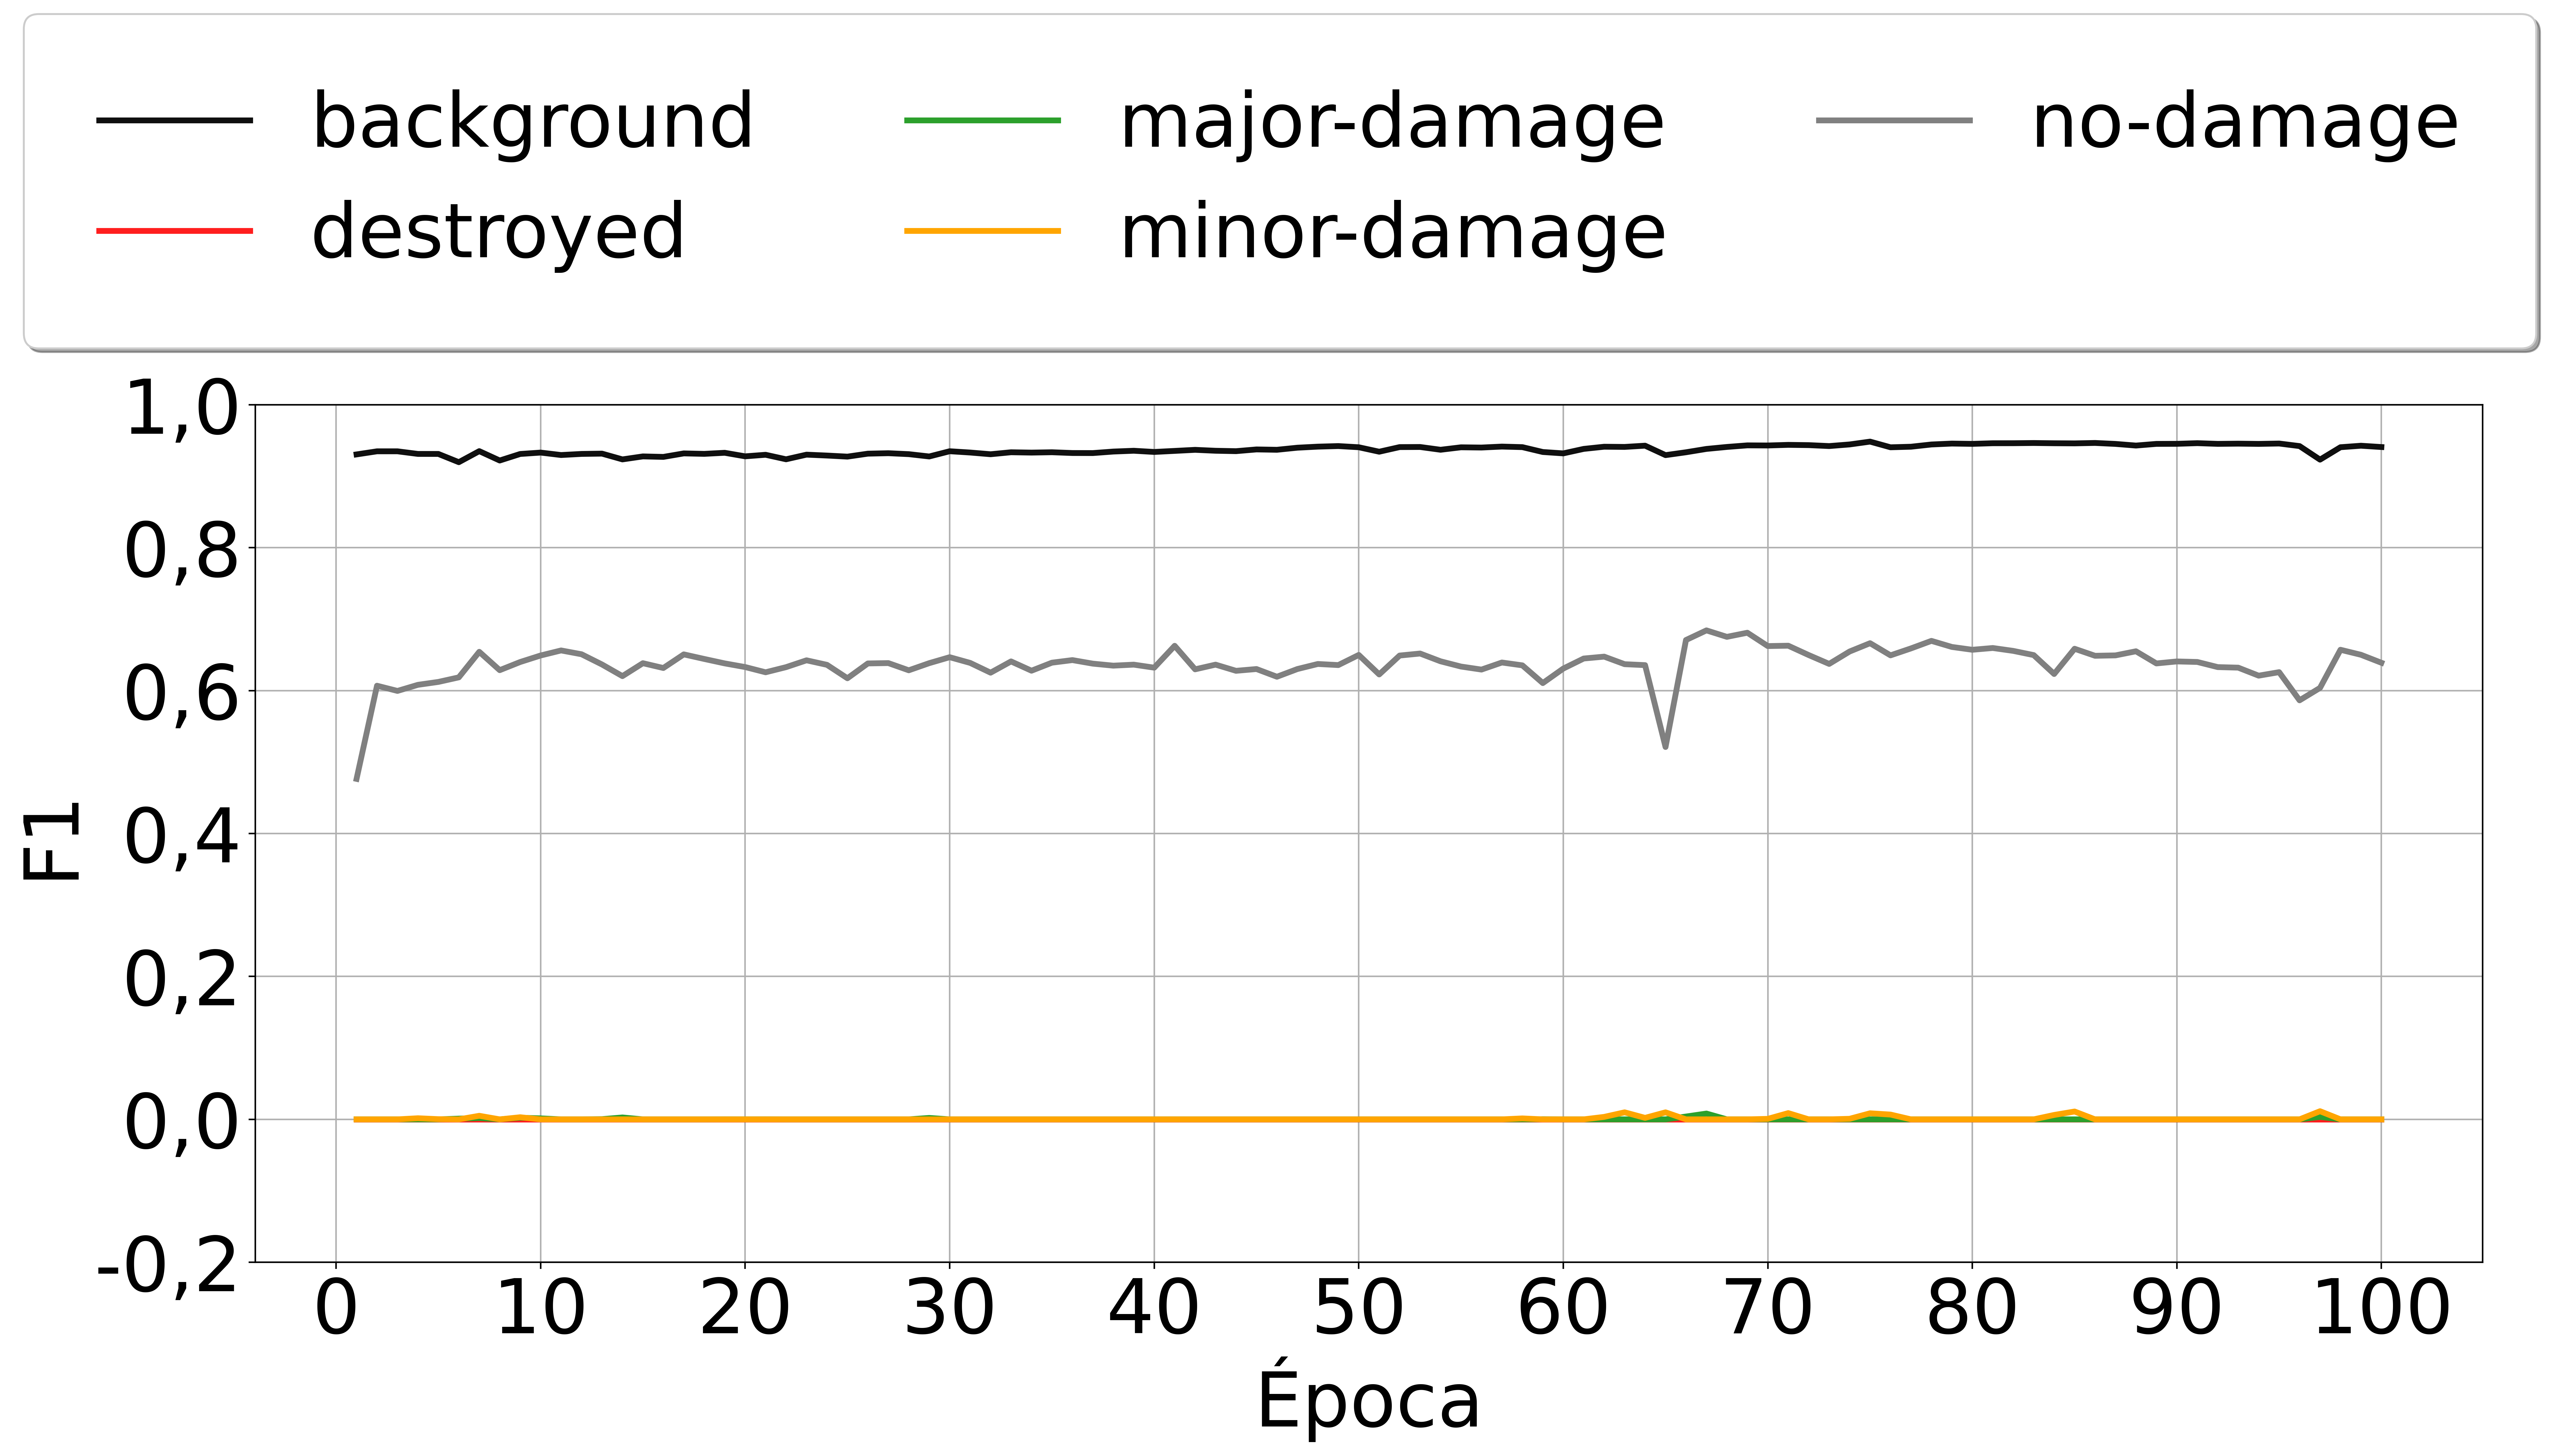

In [13]:
def_metric_dir = path.join("final_model/metrics/csv")

# loss_plots
loss_train_df = pd.read_csv(def_metric_dir.join("train_loss.csv"))
loss_train_df = loss_train_df.set_index("epoch")

loss_val_df = pd.read_csv(def_metric_dir.join("val_loss.csv"))
loss_val_df = loss_val_df.set_index("epoch")

plot_loss(loss_train_df, loss_val_df, 10)

dmg_train_df = pd.read_csv(def_metric_dir.join("train_dmg_pixel_level.csv"))
dmg_val_df = pd.read_csv(def_metric_dir.join("val_dmg_pixel_level.csv"))

plot_harmonic_mean(dmg_train_df, dmg_val_df, 10)

# val_f1_plots
dmg_val_df = pd.read_csv(def_metric_dir.join("val_dmg_pixel_level.csv"))
plot_metric_per_class(dmg_val_df, "f1", 10, loc='lower left')

# Experimento 2

In [600]:
path = FilePath("/home/mrtc101/Desktop/tesina/repo/prev_outs/exp7/out")

In [601]:
wei_df = build_weights_table(path)
wei_df

Class  Weight
0    background    3.01
1      building    1.50
2    background    3.01
3     no-damage    3.24
4  minor-damage    6.72
5  major-damage    8.71
6     destroyed   10.43

In [602]:
print(wei_df.to_latex(index=False,float_format="%.2f"))


\begin{tabular}{lr}
\toprule
Class & Weight \\
\midrule
background & 3.01 \\
building & 1.50 \\
background & 3.01 \\
no-damage & 3.24 \\
minor-damage & 6.72 \\
major-damage & 8.71 \\
destroyed & 10.43 \\
\bottomrule
\end{tabular}



In [603]:
params_df = build_conf_table(path)
params_df

Number  Batch size  Learning rate  Total epochs
0  Config 0          16         0.0010           100
1  Config 1          16         0.0001           100
2  Config 2          32         0.0010           100
3  Config 3          32         0.0001           100
4  Config 4          64         0.0010           100
5  Config 5          64         0.0001           100

In [604]:
fold_df = build_fold_table(path)
fold_df

Best epoch  val-loss  HMf1-dmg  HFM1-seg
Conf Fold                                          
C0   F0             8    0.1424    0.6927    0.8727
     F1            36    0.1289    0.7204    0.9092
     F2            72    0.1736    0.7000    0.9057
     F3            29    0.1168    0.7469    0.9026
     F4            56    0.1316    0.7092    0.9089
C1   F0            87    0.1287    0.7223    0.8934
     F1            51    0.1700    0.6469    0.8869
     F2            73    0.1140    0.7522    0.8977
     F3            92    0.1144    0.7457    0.8988
     F4            94    0.1222    0.7454    0.8979
C2   F0            70    0.0608    0.7068    0.9006
     F1            13    0.0607    0.6892    0.8968
     F2            35    0.0636    0.6711    0.9020
     F3            29    0.0572    0.7069    0.8994
     F4             5    0.0627    0.7068    0.8707
C3   F0            39    0.0637    0.6304    0.8827
     F1            42    0.0617    0.6485    0.8864
     F2            75    0.0624    0.6710    0.8912
     F3            92    0.0630    0.6810    0.8922
     F4            83    0.0736    0.5709    0.8886
C4   F0            75    0.0409    0.6935    0.9040
     F1            26    0.0346    0.6727    0.8878
     F2            30    0.0314    0.6657    0.8882
     F3            52    0.0330    0.6156    0.9009
     F4            55    0.0385    0.7181    0.9015
C5   F0            16    0.0300    0.6132    0.8770
     F1            87    0.0324    0.5631    0.8567
     F2            10    0.0314    0.5783    0.8654
     F3            44    0.0300    0.6125    0.8763
     F4            33    0.0309    0.6330    0.8755

In [605]:
print(fold_df.to_latex(index=True,float_format="%.4f"))


\begin{tabular}{llrrrr}
\toprule
 &  & Best epoch & val-loss & HMf1-dmg & HFM1-seg \\
Conf & Fold &  &  &  &  \\
\midrule
\multirow[t]{5}{*}{C0} & F0 & 8 & 0.1424 & 0.6927 & 0.8727 \\
 & F1 & 36 & 0.1289 & 0.7204 & 0.9092 \\
 & F2 & 72 & 0.1736 & 0.7000 & 0.9057 \\
 & F3 & 29 & 0.1168 & 0.7469 & 0.9026 \\
 & F4 & 56 & 0.1316 & 0.7092 & 0.9089 \\
\cline{1-6}
\multirow[t]{5}{*}{C1} & F0 & 87 & 0.1287 & 0.7223 & 0.8934 \\
 & F1 & 51 & 0.1700 & 0.6469 & 0.8869 \\
 & F2 & 73 & 0.1140 & 0.7522 & 0.8977 \\
 & F3 & 92 & 0.1144 & 0.7457 & 0.8988 \\
 & F4 & 94 & 0.1222 & 0.7454 & 0.8979 \\
\cline{1-6}
\multirow[t]{5}{*}{C2} & F0 & 70 & 0.0608 & 0.7068 & 0.9006 \\
 & F1 & 13 & 0.0607 & 0.6892 & 0.8968 \\
 & F2 & 35 & 0.0636 & 0.6711 & 0.9020 \\
 & F3 & 29 & 0.0572 & 0.7069 & 0.8994 \\
 & F4 & 5 & 0.0627 & 0.7068 & 0.8707 \\
\cline{1-6}
\multirow[t]{5}{*}{C3} & F0 & 39 & 0.0637 & 0.6304 & 0.8827 \\
 & F1 & 42 & 0.0617 & 0.6485 & 0.8864 \\
 & F2 & 75 & 0.0624 & 0.6710 & 0.8912 \\
 & F3 & 92 & 0.063

In [606]:
header, table = build_val_test_table(path, fold_df)
print(header)
table
print(table.to_latex(index=True,float_format="%.4f"))

Mejor Configuración: ('C1', 'F2') \quad Mejor época: 7 \quad \emph{val\_loss} = 0.1552
\begin{tabular}{lllrrrr}
\toprule
 &  &  & precision & recall & f1 & accuracy \\
split & hf1 & class &  &  &  &  \\
\midrule
\multirow[t]{7}{*}{validation} & \multirow[t]{2}{*}{0.584500} & background & 0.8833 & 0.7853 & 0.8315 & 0.7421 \\
 &  & building & 0.3783 & 0.5574 & 0.4507 & 0.7421 \\
\cline{2-7}
 & \multirow[t]{5}{*}{0.000000} & background & 0.8837 & 0.7850 & 0.8315 & 0.7420 \\
 &  & no-damage & 0.3558 & 0.3627 & 0.3592 & 0.7585 \\
 &  & minor-damage & 0.0035 & 0.0310 & 0.0063 & 0.9754 \\
 &  & major-damage & 0.0000 & 0.0025 & 0.0000 & 0.9504 \\
 &  & destroyed & 0.0000 & 0.0000 & 0.0000 & 0.9824 \\
\cline{1-7} \cline{2-7}
\bottomrule
\end{tabular}



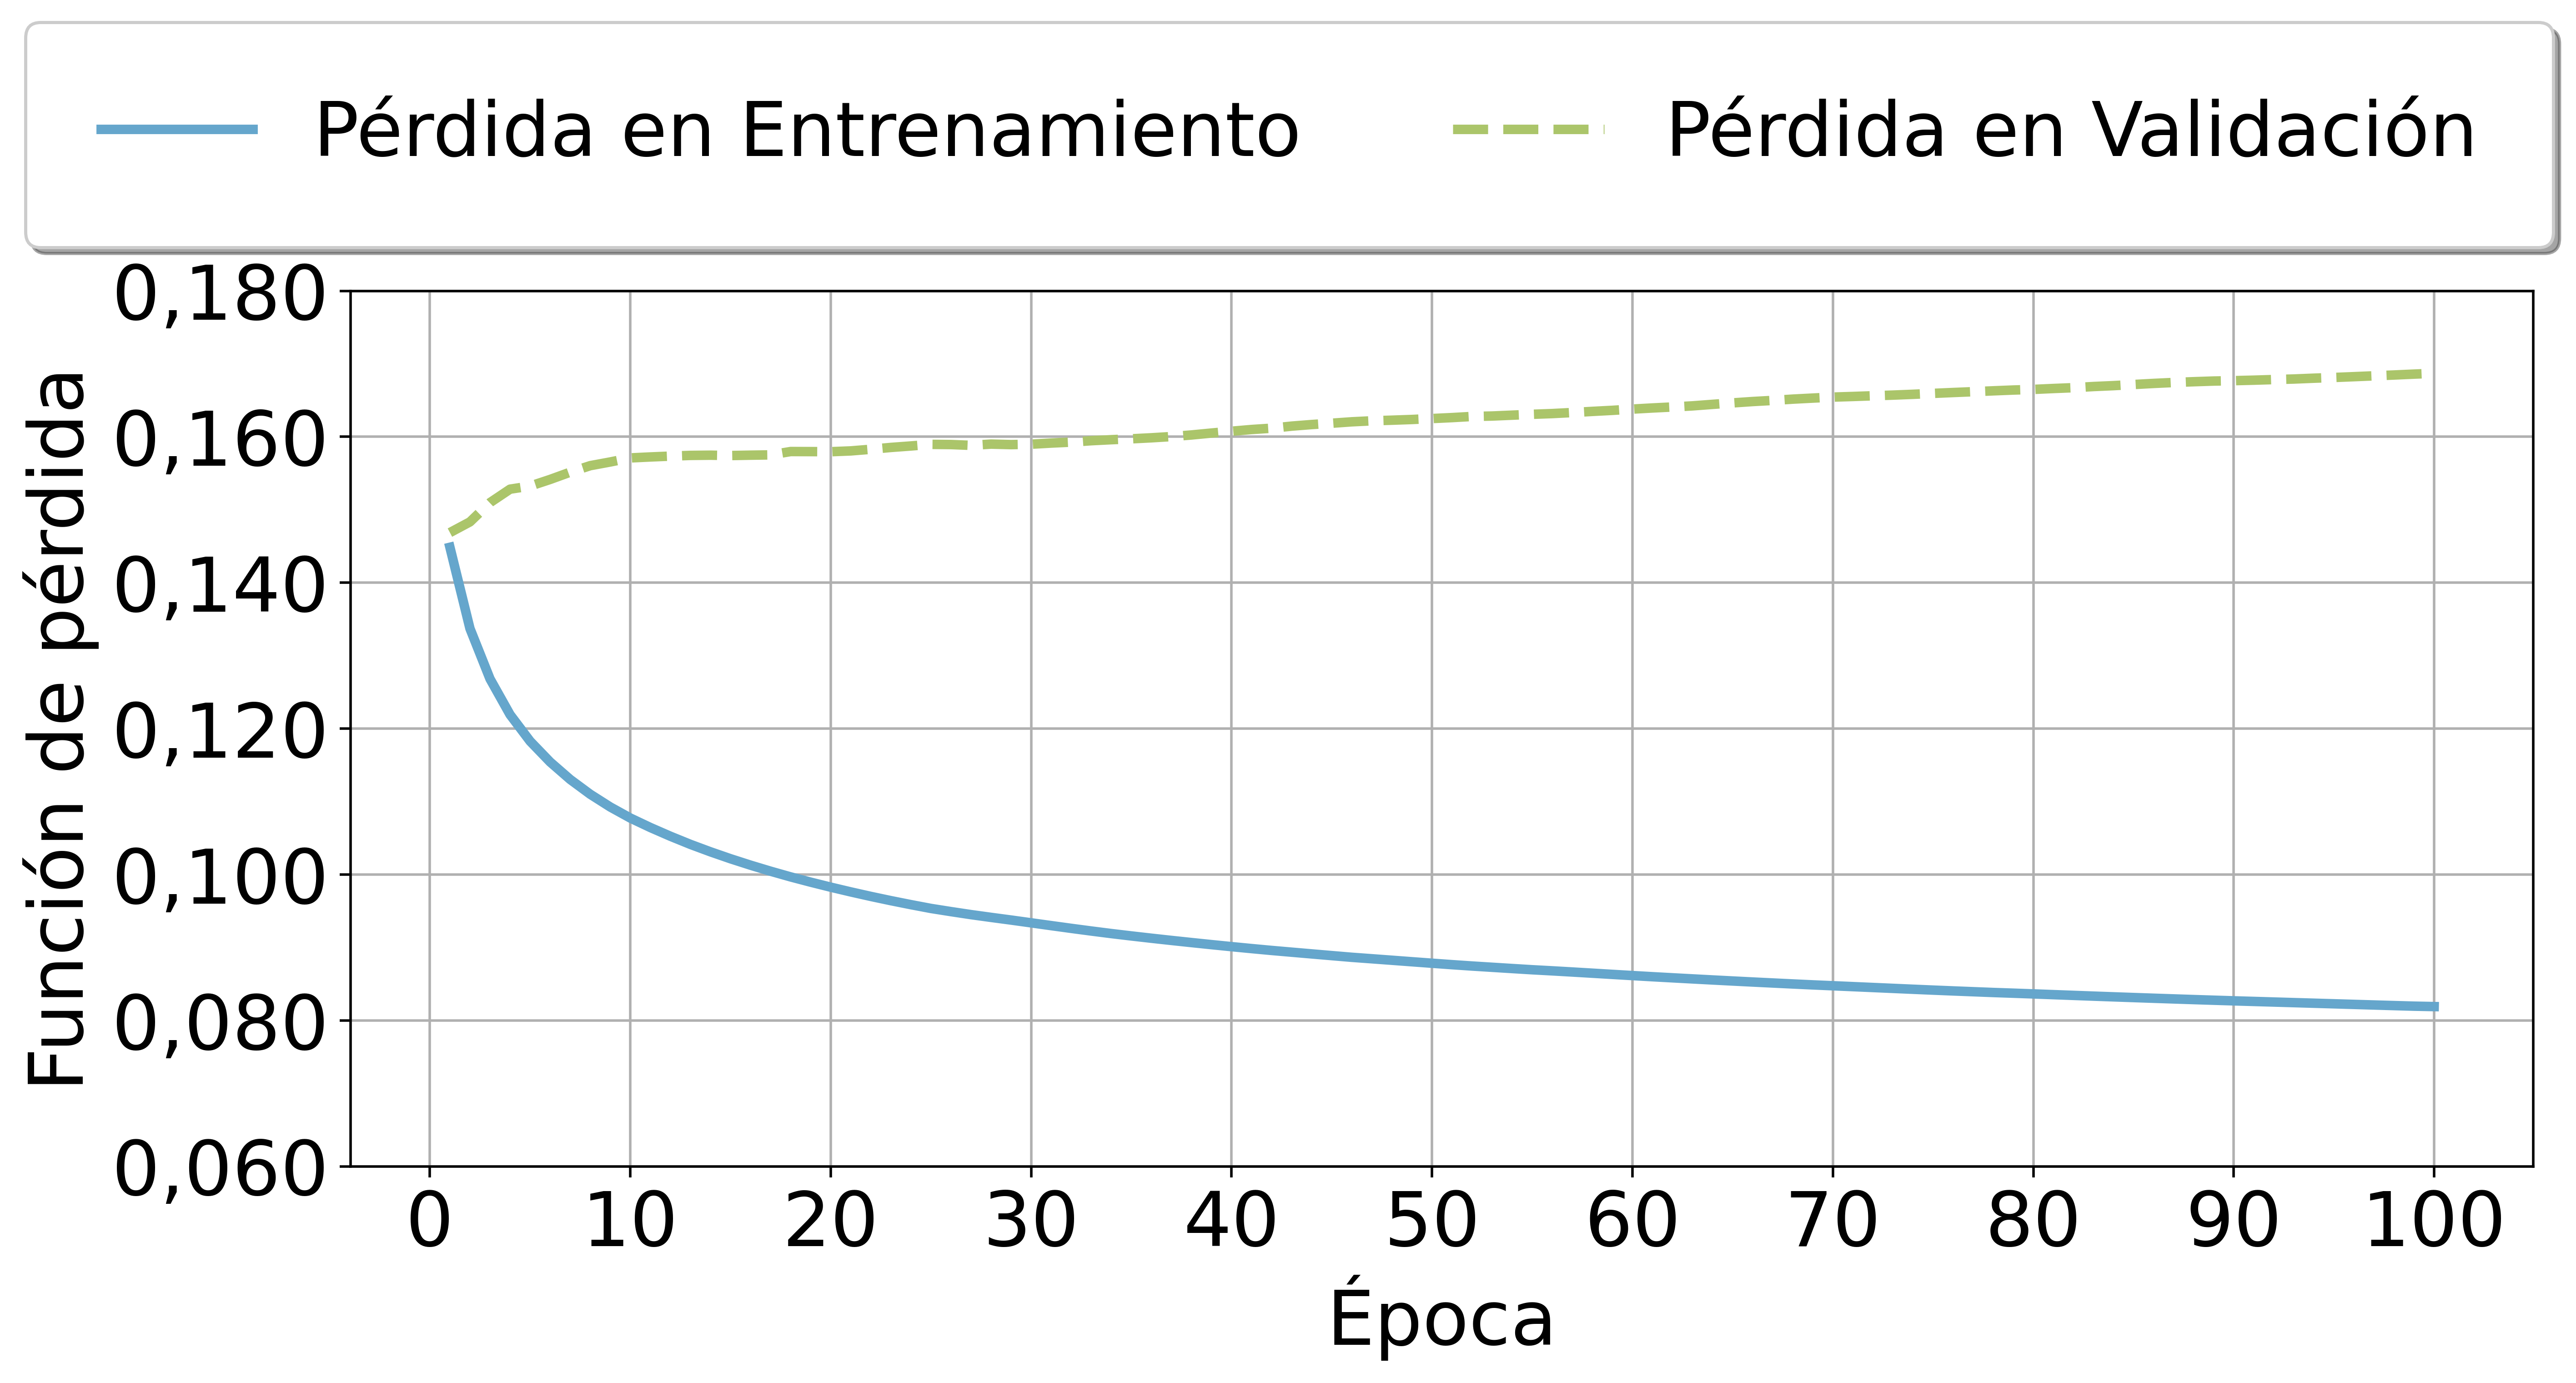

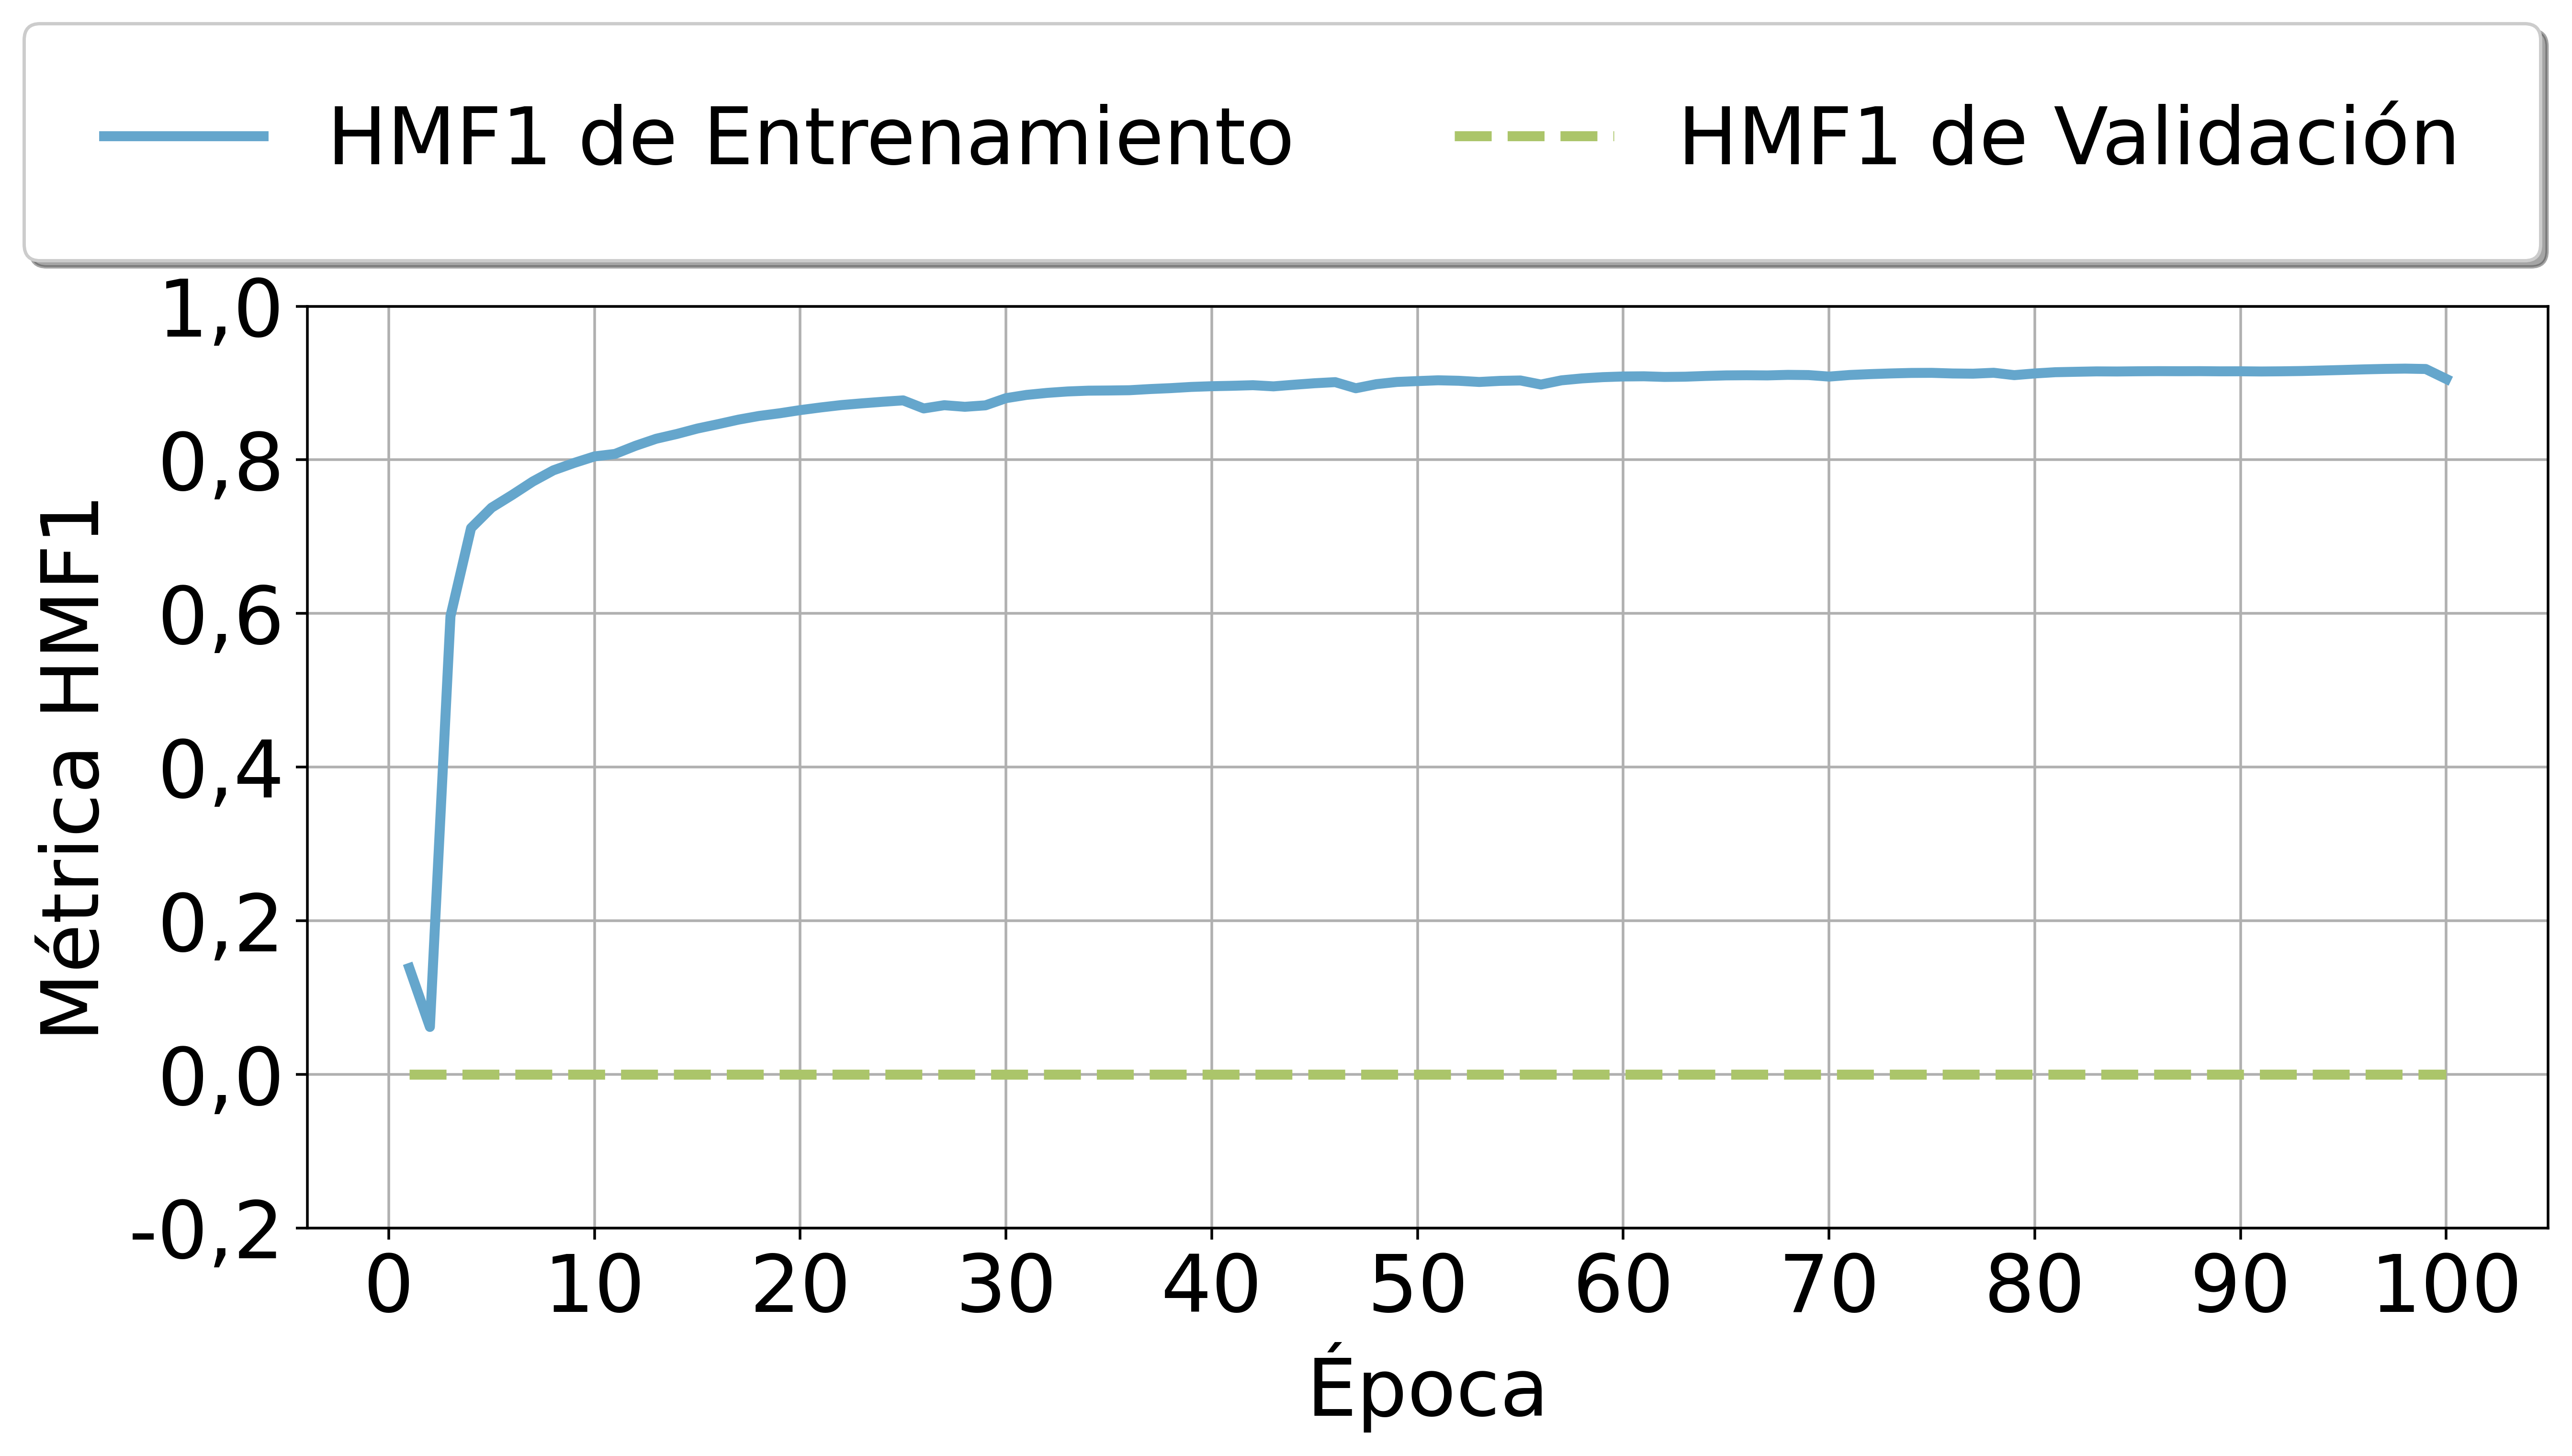

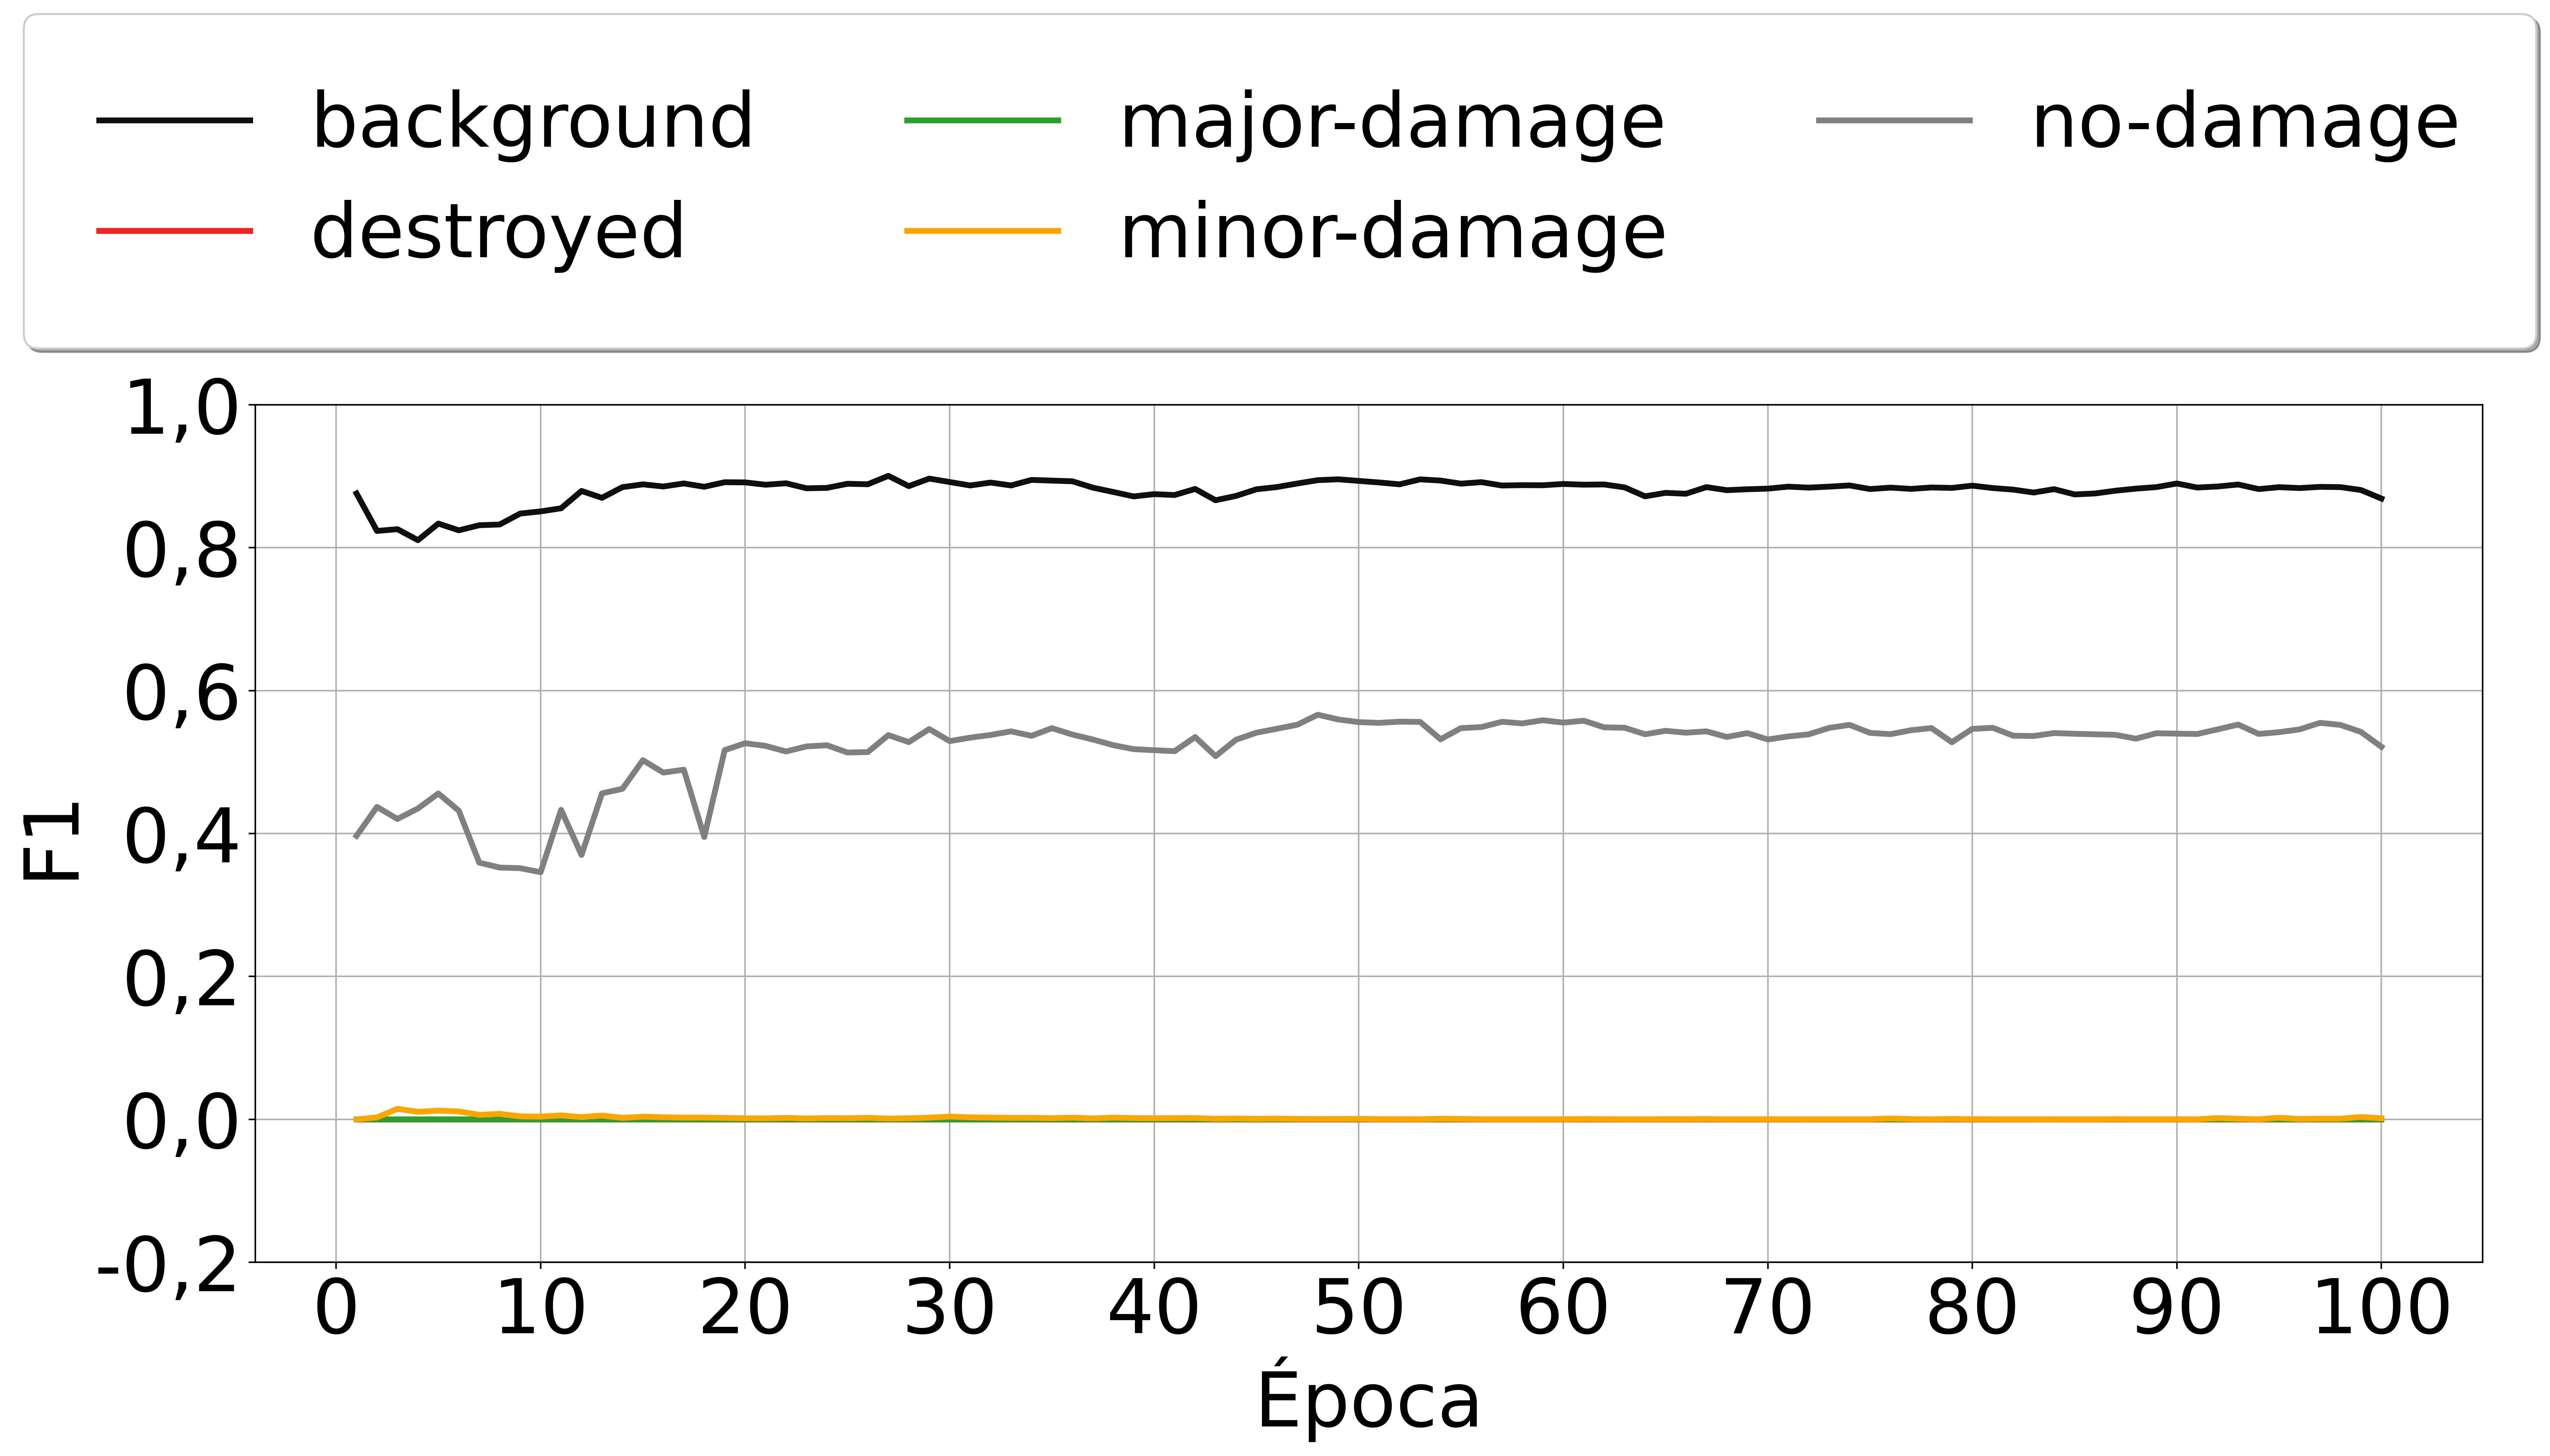

In [607]:
def_metric_dir = path.join("final_model/metrics/csv")

# loss_plots
loss_train_df = pd.read_csv(def_metric_dir.join("train_loss.csv"))
loss_train_df = loss_train_df.set_index("epoch")

loss_val_df = pd.read_csv(def_metric_dir.join("val_loss.csv"))
loss_val_df = loss_val_df.set_index("epoch")

plot_loss(loss_train_df, loss_val_df, 10)

dmg_train_df = pd.read_csv(def_metric_dir.join("train_dmg_pixel_level.csv"))
dmg_val_df = pd.read_csv(def_metric_dir.join("val_dmg_pixel_level.csv"))

plot_harmonic_mean(dmg_train_df, dmg_val_df, 10)

# val_f1_plots
dmg_val_df = pd.read_csv(def_metric_dir.join("val_dmg_pixel_level.csv"))
plot_metric_per_class(dmg_val_df, "f1", 10, loc='lower right')

# Experimento  3

In [608]:
path = FilePath("/home/mrtc101/Desktop/tesina/repo/prev_outs/exp5/exp5/out")

In [609]:
wei_df = build_weights_table(path)
wei_df

Class  Weight
0    background    1.56
1      building    2.77
2    background    1.56
3     no-damage    6.76
4  minor-damage   15.22
5  major-damage   13.66
6     destroyed   13.59

In [610]:
print(wei_df.to_latex(index=False,float_format="%.2f"))

\begin{tabular}{lr}
\toprule
Class & Weight \\
\midrule
background & 1.56 \\
building & 2.77 \\
background & 1.56 \\
no-damage & 6.76 \\
minor-damage & 15.22 \\
major-damage & 13.66 \\
destroyed & 13.59 \\
\bottomrule
\end{tabular}



In [611]:
params_df = build_conf_table(path)
params_df

Number  Batch size  Learning rate  Total epochs
0  Config 0          16       0.000001            50
1  Config 1          16       0.000010            50
2  Config 2          16       0.000100            50
3  Config 3          16       0.001000            50
4  Config 4          16       0.010000            50
5  Config 5          16       0.100000            50

In [612]:
print(params_df.to_latex(index=False,float_format="%.6f"))

\begin{tabular}{lrrr}
\toprule
Number & Batch size & Learning rate & Total epochs \\
\midrule
Config 0 & 16 & 0.000001 & 50 \\
Config 1 & 16 & 0.000010 & 50 \\
Config 2 & 16 & 0.000100 & 50 \\
Config 3 & 16 & 0.001000 & 50 \\
Config 4 & 16 & 0.010000 & 50 \\
Config 5 & 16 & 0.100000 & 50 \\
\bottomrule
\end{tabular}



In [613]:
fold_df = build_fold_table(path)
fold_df

Best epoch  val-loss  HMf1-dmg  HFM1-seg
Conf Fold                                          
C0   F0            48    0.1652    0.0853    0.6153
     F1            50    0.1268    0.2625    0.7529
     F2            50    0.1554    0.0660    0.6931
     F3             7    0.1889    0.0441    0.2573
     F4            31    0.2067    0.0832    0.3151
C1   F0            48    0.1113    0.5385    0.8386
     F1            48    0.1115    0.5276    0.8454
     F2            49    0.1179    0.5191    0.8313
     F3            45    0.1160    0.5222    0.8375
     F4            49    0.1180    0.5102    0.8220
C2   F0            45    0.1078    0.6108    0.8622
     F1            37    0.1046    0.6332    0.8713
     F2            38    0.1060    0.6280    0.8706
     F3            17    0.1083    0.6245    0.8683
     F4            43    0.1066    0.6245    0.8780
C3   F0            32    0.1035    0.6332    0.8759
     F1            42    0.1035    0.6406    0.8775
     F2            21    0.1033    0.6498    0.8809
     F3            23    0.1036    0.6440    0.8830
     F4            43    0.1051    0.6252    0.8815
C4   F0            29    0.1039    0.6100    0.8709
     F1            42    0.1058    0.6012    0.8762
     F2            26    0.1079    0.5531    0.8365
     F3            36    0.1048    0.6271    0.8723
     F4            44    0.1053    0.5999    0.8784
C5   F0            37    0.1166    0.0000    0.8156
     F1            48    0.1117    0.0000    0.8562
     F2             3    0.1188    0.0000    0.7272
     F3            25    0.1138    0.0000    0.8426
     F4            42    0.1163    0.0000    0.8487

In [614]:
print(fold_df.to_latex(index=True,float_format="%.4f"))


\begin{tabular}{llrrrr}
\toprule
 &  & Best epoch & val-loss & HMf1-dmg & HFM1-seg \\
Conf & Fold &  &  &  &  \\
\midrule
\multirow[t]{5}{*}{C0} & F0 & 48 & 0.1652 & 0.0853 & 0.6153 \\
 & F1 & 50 & 0.1268 & 0.2625 & 0.7529 \\
 & F2 & 50 & 0.1554 & 0.0660 & 0.6931 \\
 & F3 & 7 & 0.1889 & 0.0441 & 0.2573 \\
 & F4 & 31 & 0.2067 & 0.0832 & 0.3151 \\
\cline{1-6}
\multirow[t]{5}{*}{C1} & F0 & 48 & 0.1113 & 0.5385 & 0.8386 \\
 & F1 & 48 & 0.1115 & 0.5276 & 0.8454 \\
 & F2 & 49 & 0.1179 & 0.5191 & 0.8313 \\
 & F3 & 45 & 0.1160 & 0.5222 & 0.8375 \\
 & F4 & 49 & 0.1180 & 0.5102 & 0.8220 \\
\cline{1-6}
\multirow[t]{5}{*}{C2} & F0 & 45 & 0.1078 & 0.6108 & 0.8622 \\
 & F1 & 37 & 0.1046 & 0.6332 & 0.8713 \\
 & F2 & 38 & 0.1060 & 0.6280 & 0.8706 \\
 & F3 & 17 & 0.1083 & 0.6245 & 0.8683 \\
 & F4 & 43 & 0.1066 & 0.6245 & 0.8780 \\
\cline{1-6}
\multirow[t]{5}{*}{C3} & F0 & 32 & 0.1035 & 0.6332 & 0.8759 \\
 & F1 & 42 & 0.1035 & 0.6406 & 0.8775 \\
 & F2 & 21 & 0.1033 & 0.6498 & 0.8809 \\
 & F3 & 23 & 0.10

In [615]:
exp_5_path = FilePath('/home/mrtc101/Desktop/tesina/repo/prev_outs/exp8')

exp_folders = [fol_name for fol_name in exp_5_path.get_folder_names() if fol_name.startswith("exp")]
conf_list = []
for dir in exp_folders:
    out_path = exp_5_path.join(dir, "out")
    conf_dict = out_path.join("conf_list.json").read_json()
    rlrop_patience = conf_dict.get("0")["RLROP_patience"]
    metric_dir = out_path.join("final_model/metrics/csv")
    bld_df, dmg_df, loss_df = load_metric_dfs("val", metric_dir)
    best_epoch = dmg_df["f1_harmonic_mean"].idxmax()[0]
    val_loss = loss_df.loc[best_epoch].iloc[0]
    seg_hf1 = bld_df.loc[best_epoch, 0]["f1_harmonic_mean"]
    dmg_hf1 = dmg_df.loc[best_epoch, 0]["f1_harmonic_mean"]
    row = [f"C_{rlrop_patience}", best_epoch, val_loss, dmg_hf1, seg_hf1]
    conf_list.append(row)

conf_df = pd.DataFrame(conf_list, columns=["Conf", "Best epoch", "val-loss", "HMf1-dmg", "HFM1-seg"])
conf_df = conf_df.sort_values(by=["Conf"])
conf_df = round(conf_df, 4)
conf_df = conf_df.groupby("Conf").apply(lambda x: x, include_groups=False)
conf_df = conf_df.sort_values(["Conf"])

conf_df

Best epoch  val-loss  HMf1-dmg  HFM1-seg
Conf                                             
C_10  0          40    0.1114    0.5939    0.8640
C_20  3          32    0.1113    0.5754    0.8459
C_200 1          71    0.1120    0.6341    0.8824
C_30  2          28    0.1094    0.6002    0.8811

In [616]:
print(conf_df.to_latex(float_format="%.4f"))

\begin{tabular}{llrrrr}
\toprule
 &  & Best epoch & val-loss & HMf1-dmg & HFM1-seg \\
Conf &  &  &  &  &  \\
\midrule
C_10 & 0 & 40 & 0.1114 & 0.5939 & 0.8640 \\
\cline{1-6}
C_20 & 3 & 32 & 0.1113 & 0.5754 & 0.8459 \\
\cline{1-6}
C_200 & 1 & 71 & 0.1120 & 0.6341 & 0.8824 \\
\cline{1-6}
C_30 & 2 & 28 & 0.1094 & 0.6002 & 0.8811 \\
\cline{1-6}
\bottomrule
\end{tabular}



In [617]:
path = FilePath("/home/mrtc101/Desktop/tesina/repo/prev_outs/exp8/exp8_a/out")
header, table = build_val_test_table(path, fold_df,test=True)
print(header)
print(table.to_latex(index=True,float_format="%.4f"))

Mejor Configuración: ('C3', 'F2') \quad Mejor época: 72 \quad \emph{val\_loss} = 0.1121 \quad \emph{test\_loss} = 0.1117
\begin{tabular}{lllrrrr}
\toprule
 &  &  & precision & recall & f1 & accuracy \\
split & hf1 & class &  &  &  &  \\
\midrule
\multirow[t]{7}{*}{validation} & \multirow[t]{2}{*}{0.875700} & background & 0.9862 & 0.9934 & 0.9897 & 0.9804 \\
 &  & building & 0.8501 & 0.7295 & 0.7852 & 0.9804 \\
\cline{2-7}
 & \multirow[t]{5}{*}{0.605900} & background & 0.9865 & 0.9932 & 0.9898 & 0.9806 \\
 &  & no-damage & 0.6305 & 0.4506 & 0.5256 & 0.9863 \\
 &  & minor-damage & 0.5352 & 0.4140 & 0.4669 & 0.9897 \\
 &  & major-damage & 0.5450 & 0.5658 & 0.5552 & 0.9899 \\
 &  & destroyed & 0.7045 & 0.7279 & 0.7161 & 0.9944 \\
\cline{1-7} \cline{2-7}
\multirow[t]{7}{*}{test} & \multirow[t]{2}{*}{0.870500} & background & 0.9932 & 0.9918 & 0.9925 & 0.9855 \\
 &  & building & 0.7593 & 0.7917 & 0.7751 & 0.9855 \\
\cline{2-7}
 & \multirow[t]{5}{*}{0.557100} & background & 0.9933 & 0.9918 & 0

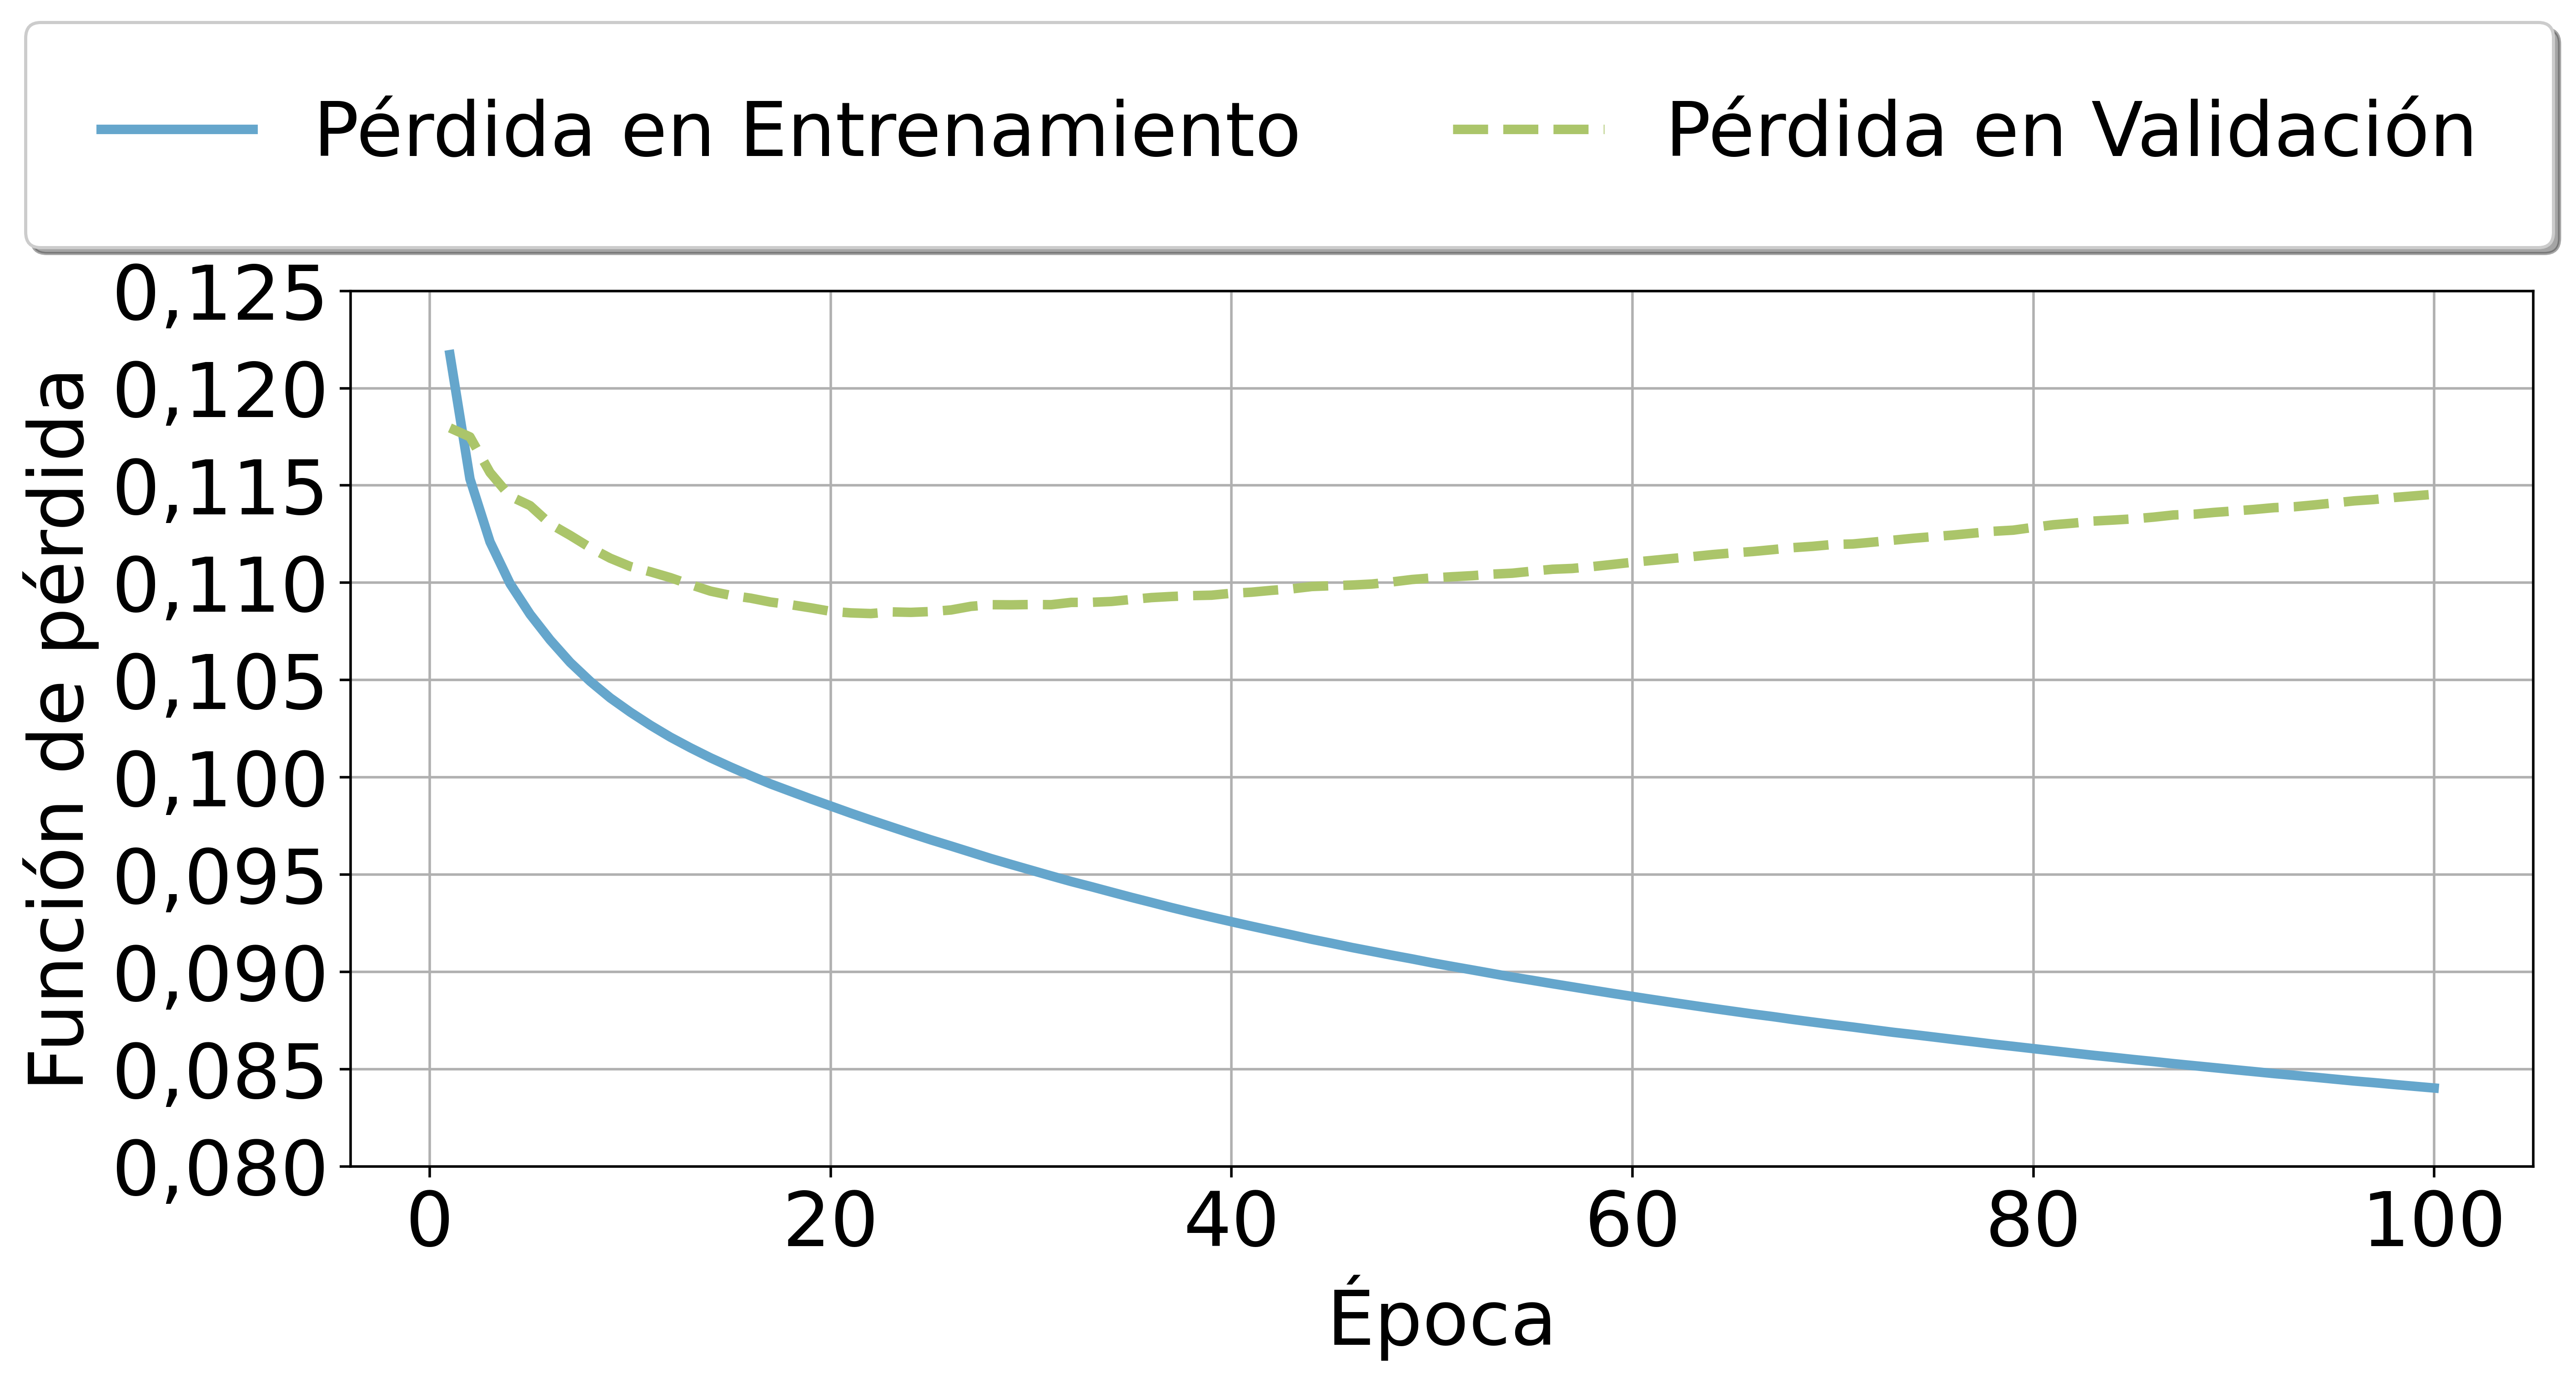

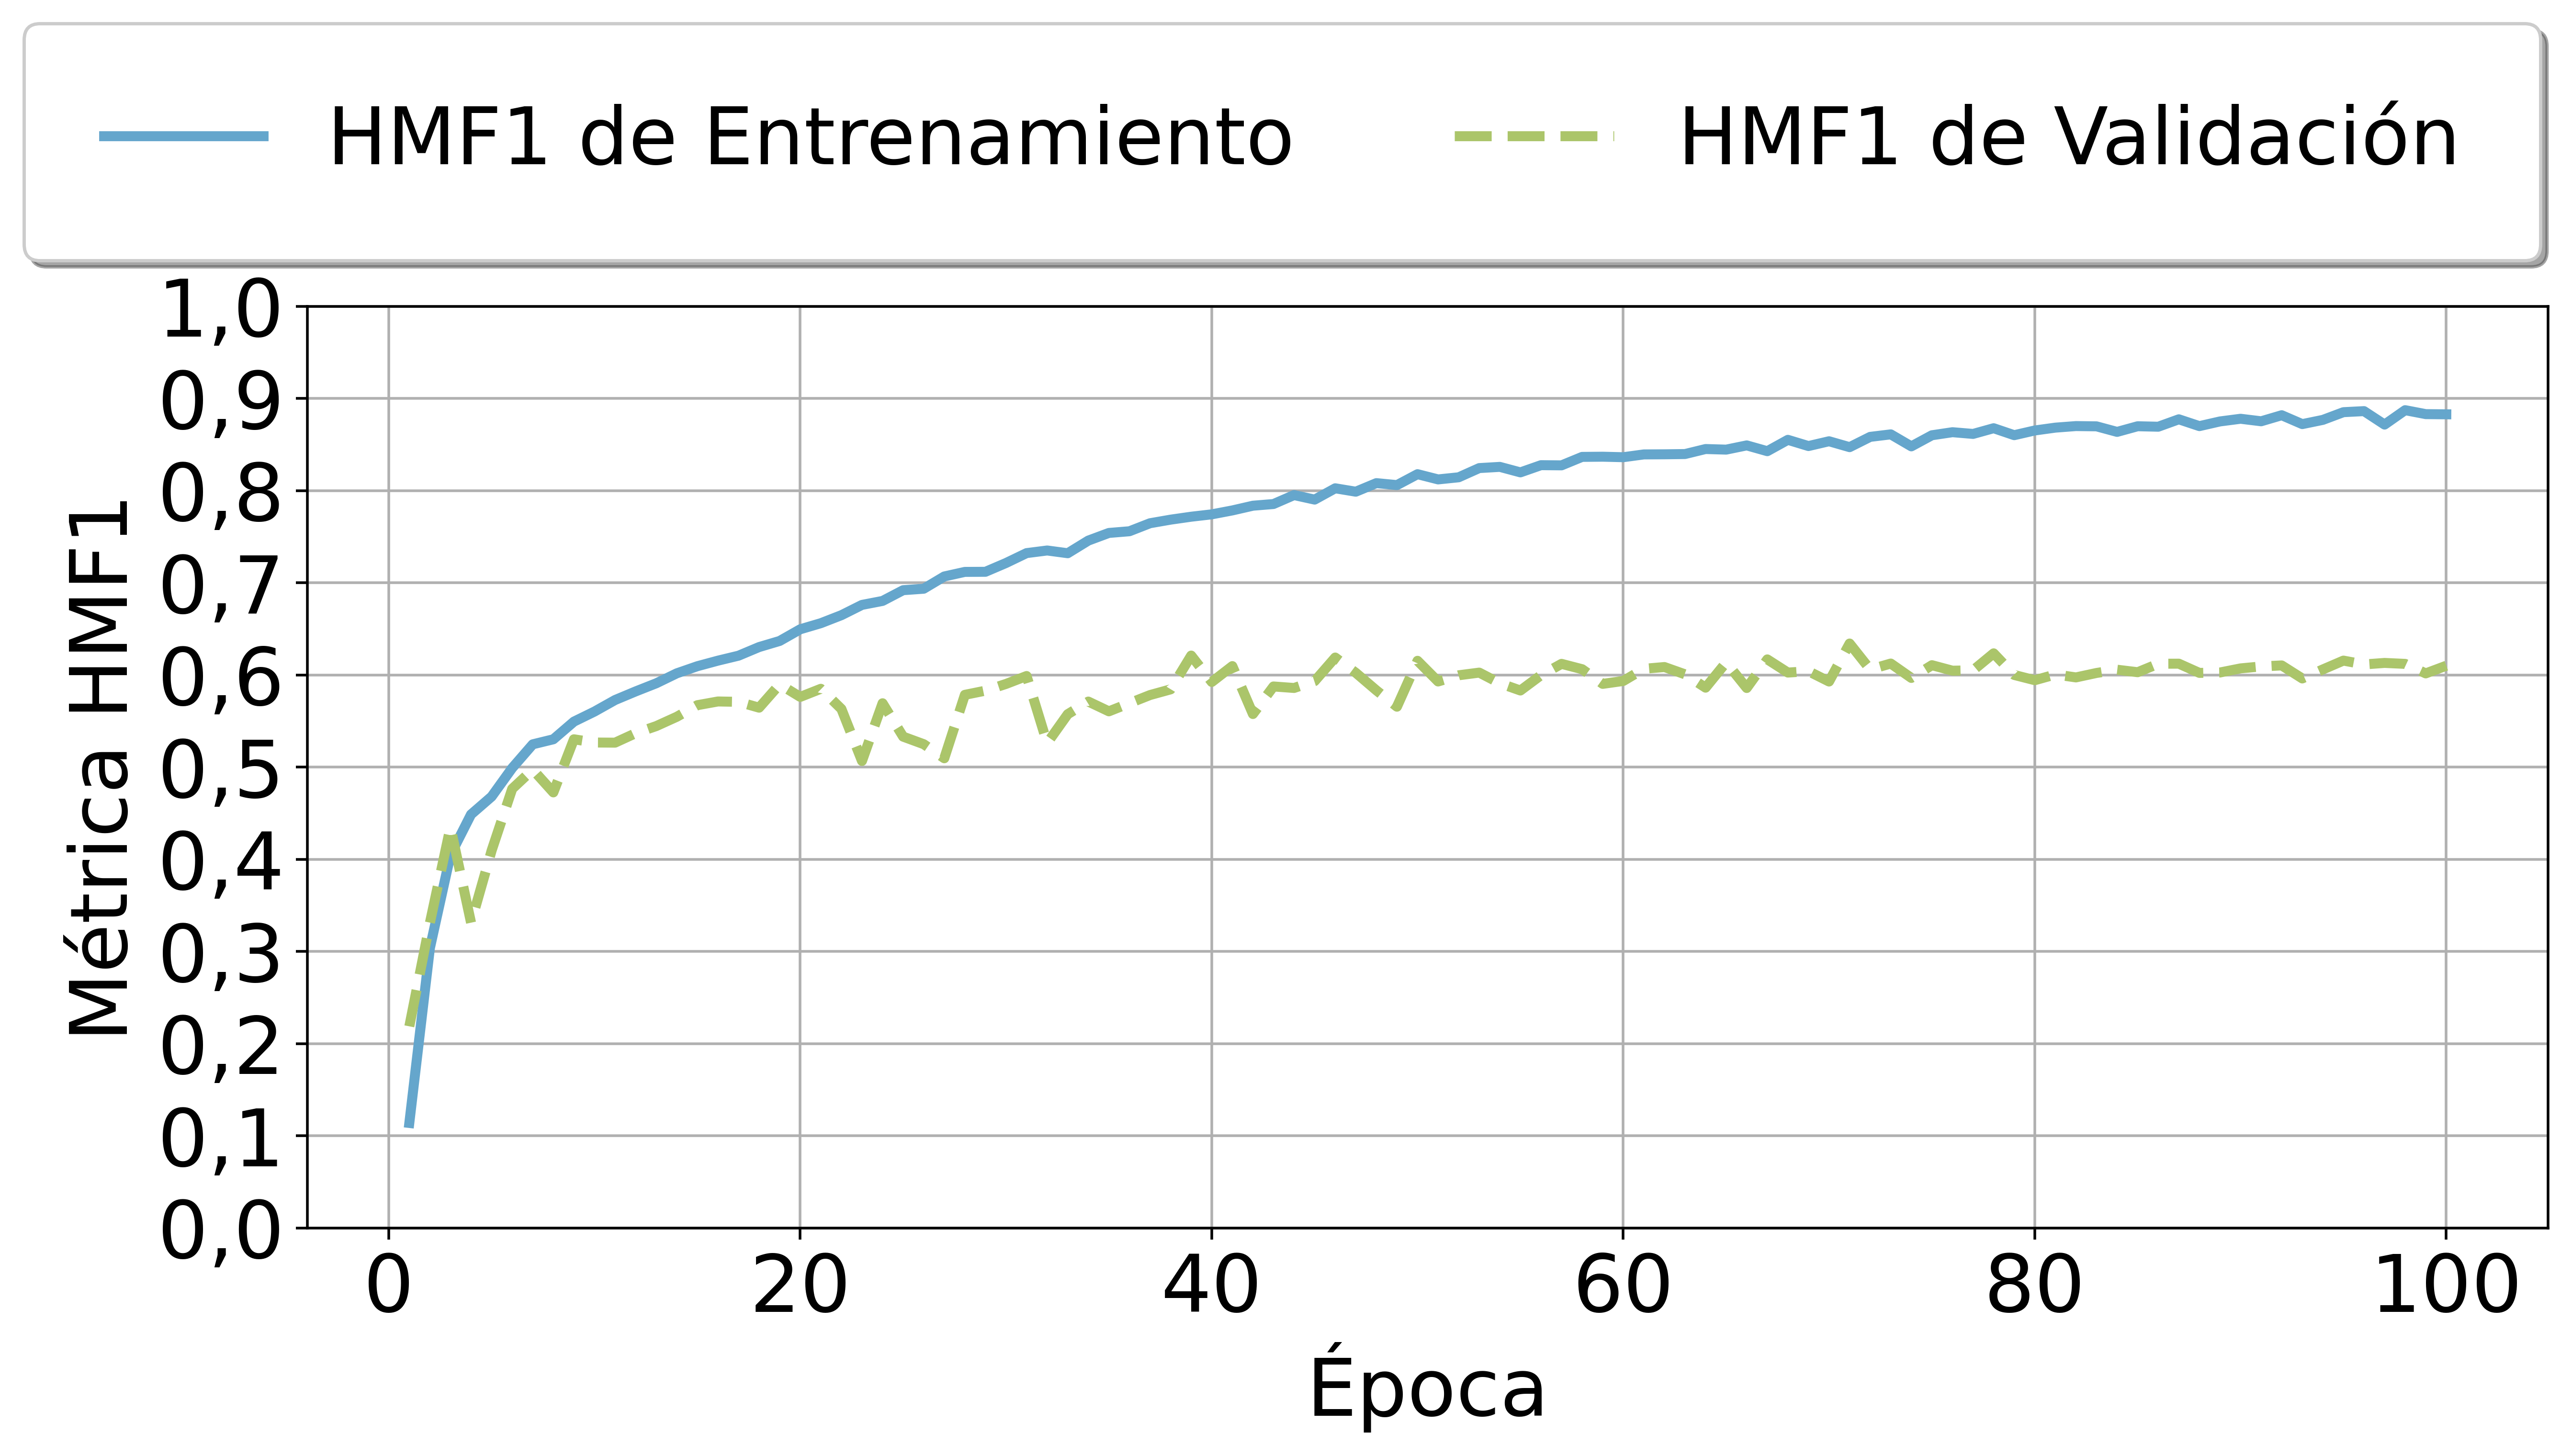

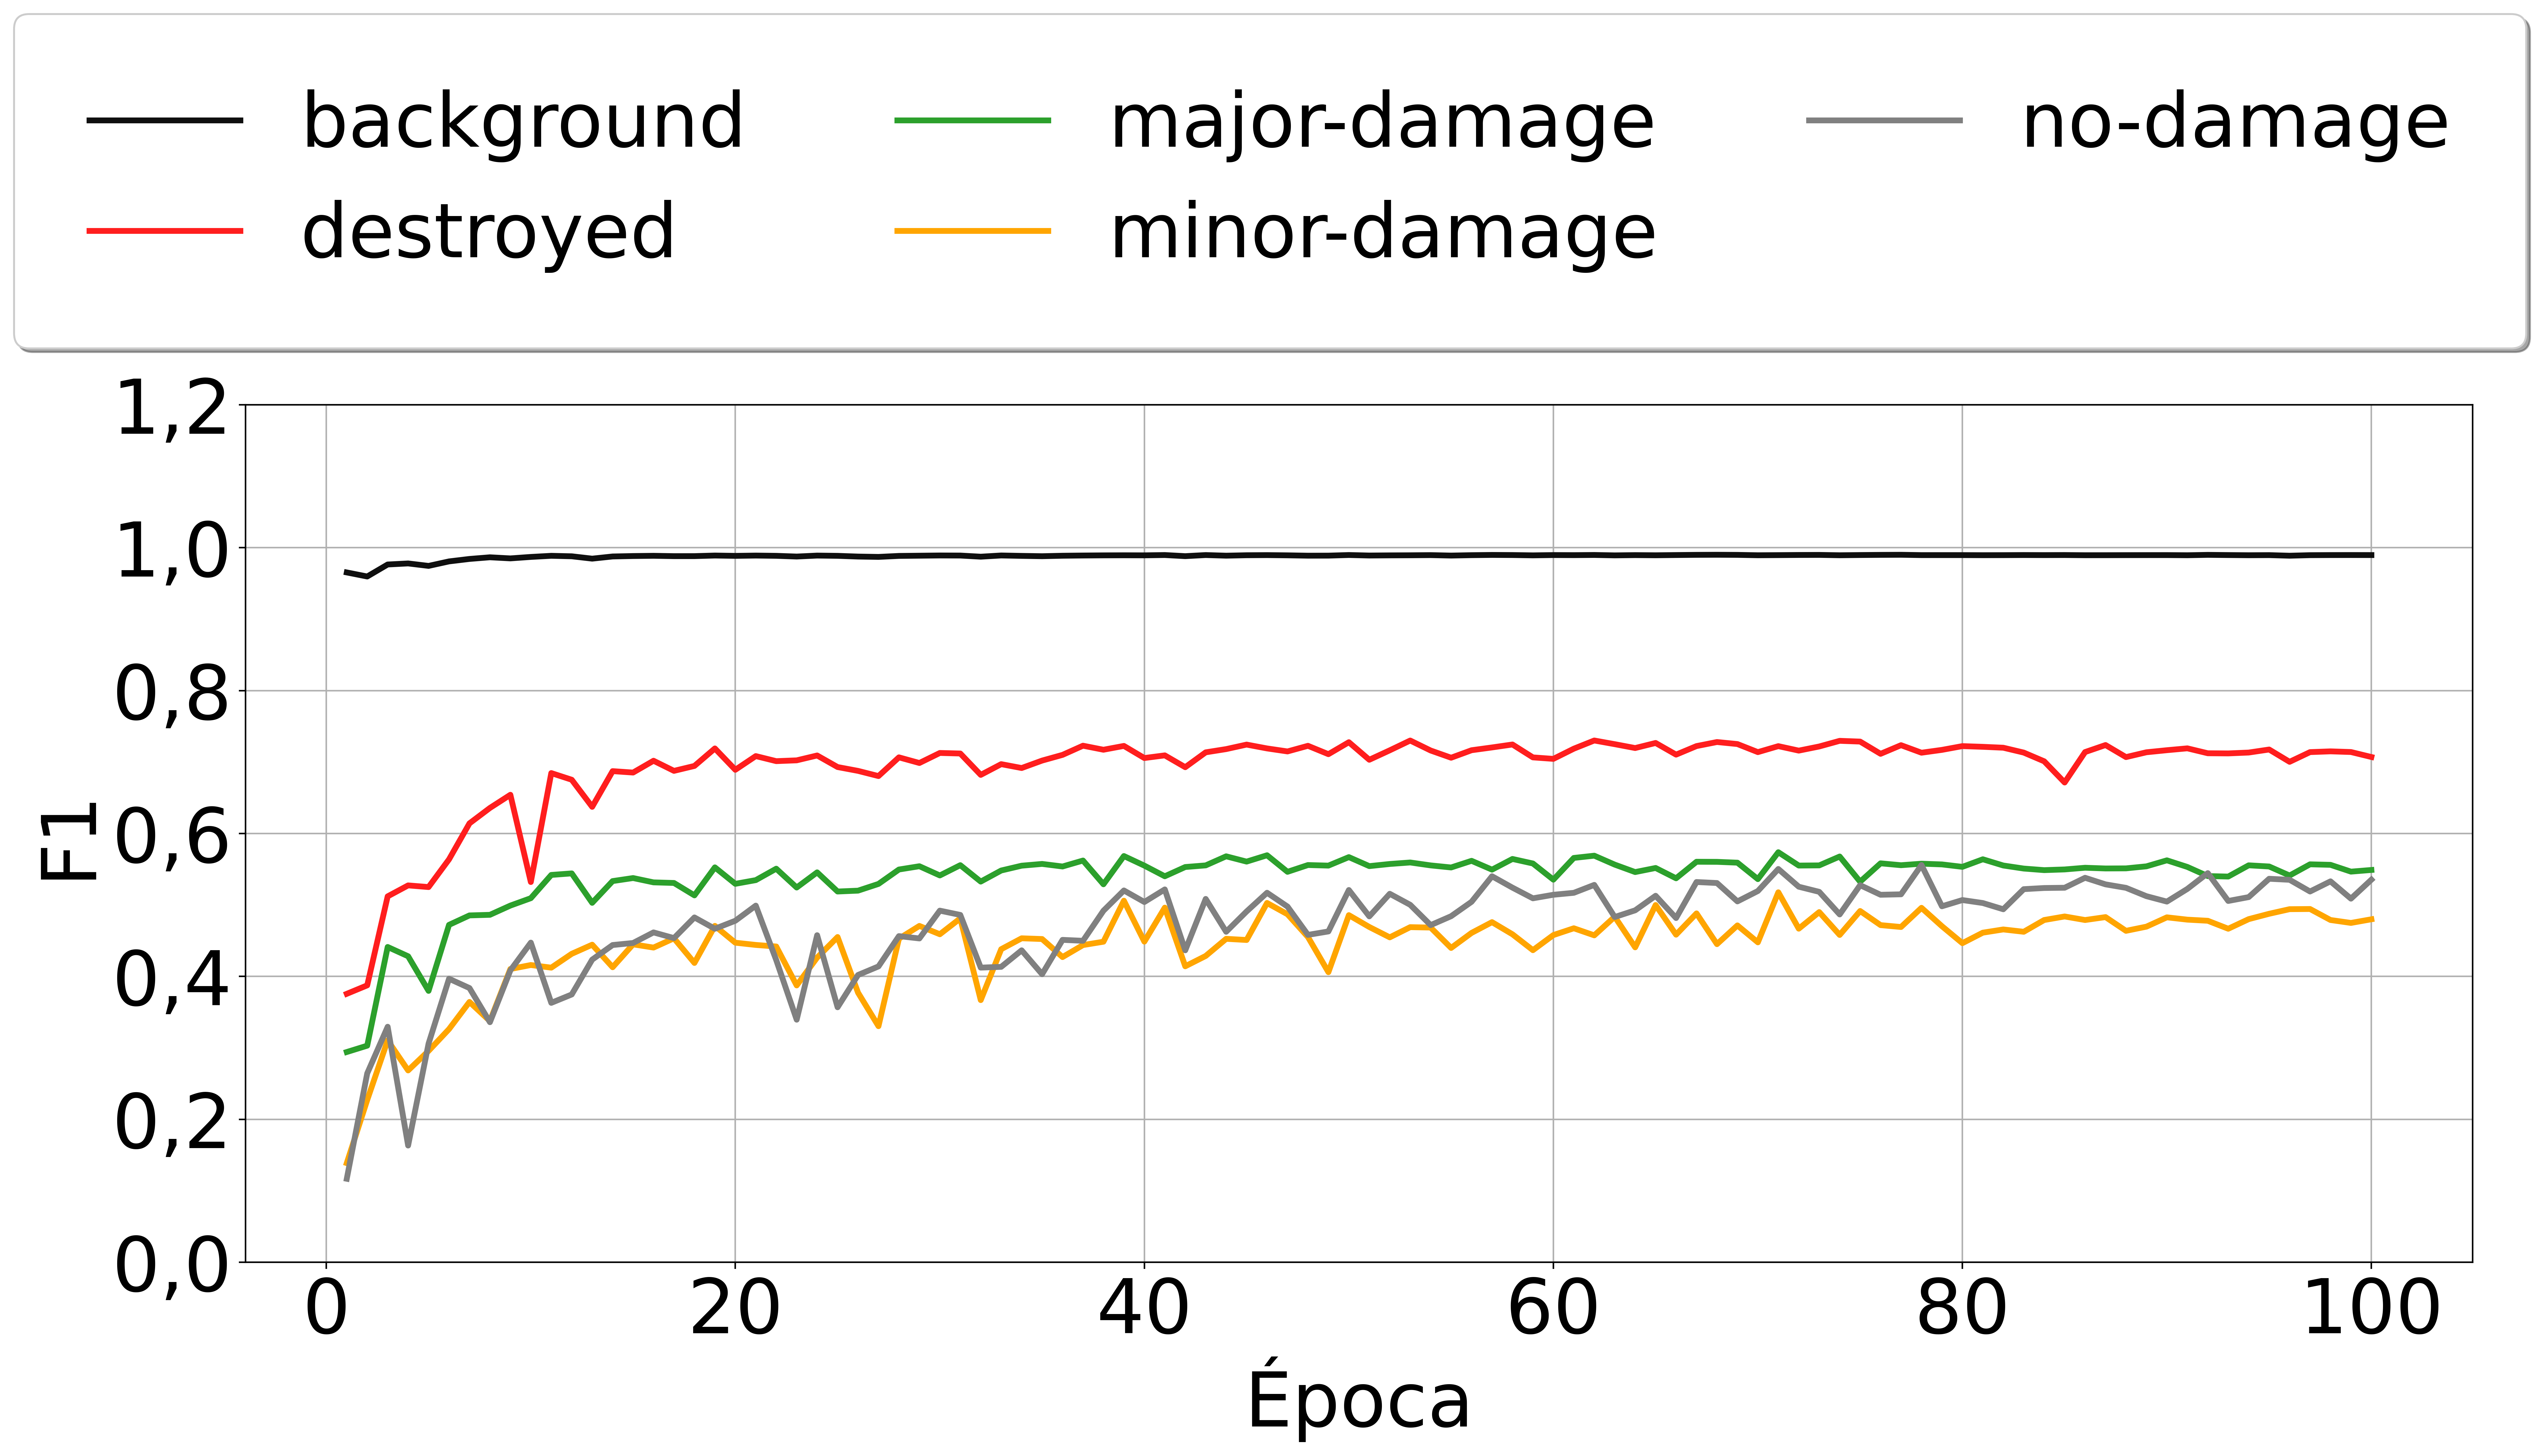

In [618]:
def_metric_dir = path.join("final_model/metrics/csv")

# loss_plots
loss_train_df = pd.read_csv(def_metric_dir.join("train_loss.csv"))
loss_train_df = loss_train_df.set_index("epoch")

loss_val_df = pd.read_csv(def_metric_dir.join("val_loss.csv"))
loss_val_df = loss_val_df.set_index("epoch")

plot_loss(loss_train_df, loss_val_df, 20)

dmg_train_df = pd.read_csv(def_metric_dir.join("train_dmg_pixel_level.csv"))
dmg_val_df = pd.read_csv(def_metric_dir.join("val_dmg_pixel_level.csv"))

plot_harmonic_mean(dmg_train_df, dmg_val_df, 20)

# val_f1_plots
dmg_val_df = pd.read_csv(def_metric_dir.join("val_dmg_pixel_level.csv"))
plot_metric_per_class(dmg_val_df, "f1", 20, loc='upper left')

#lr_df = pd.read_csv(def_metric_dir.join("lr.csv"))
#plot_lr(lr_df)

In [626]:
path = FilePath("/home/mrtc101/Desktop/tesina/repo/prev_outs/exp8/exp8_a/out")
p = path.join("postprocessing/metrics").join("pixel_multi_confusion_matrix.csv") 
mult_df = read_multi_csv(p)
mult_df

Background  No Damage  Minor Damage  Major Damage  Destroyed  \
Background     125942803     279746        288344        210081     267518   
No Damage         350081     638594        157374        108317      17119   
Minor Damage      188412     130653        313767        154873      17214   
Major Damage      152883      81373        159728        539559      79656   
Destroyed         155081      13069         25917         24875     774963   
Total          126789260    1143435        945130       1037705    1156470   

                  Total  
Background    126988492  
No Damage       1271485  
Minor Damage     804919  
Major Damage    1013199  
Destroyed        993905  
Total         131072000

In [627]:
bld_pixel_df = get_bld_px_multi(mult_df)
bld_pixel_df

Background  Building      Total
Background   125942803   1045689  126988492
Building        846457   3237051    4083508
Total        126789260   4282740  131072000

In [628]:
bld_percentual_df = get_percentual_px_multi(bld_pixel_df)
bld_percentual_df

Background  Building      Total  Total%
Background        0.99      0.01  126988492    0.97
Building          0.21      0.79    4083508    0.03
Total             0.97      0.03  131072000    1.00

In [629]:
dmg_pixel_df = get_dmg_px_multi(mult_df)
dmg_pixel_df

No Damage  Minor Damage  Major Damage  Destroyed    Total
No Damage        638594        157374        108317      17119   921404
Minor Damage     130653        313767        154873      17214   616507
Major Damage      81373        159728        539559      79656   860316
Destroyed         13069         25917         24875     774963   838824
Total            863689        656786        827624     888952  3237051

In [630]:
get_percentual_px_multi(dmg_pixel_df)

No Damage  Minor Damage  Major Damage  Destroyed    Total  \
No Damage          0.69          0.17          0.12       0.02   921404   
Minor Damage       0.21          0.51          0.25       0.03   616507   
Major Damage       0.09          0.19          0.63       0.09   860316   
Destroyed          0.02          0.03          0.03       0.92   838824   
Total              0.27          0.20          0.26       0.27  3237051   

              Total%  
No Damage       0.28  
Minor Damage    0.19  
Major Damage    0.27  
Destroyed       0.26  
Total           1.00

### Object level performance

In [631]:
labels = ["No Damage", "Minor Damage", "Major Damage", "Destroyed", "Undetected","Total"]  
p = path.join("postprocessing/metrics").join("obj_multi_confusion_matrix.csv") 
print(get_obj_mtrx(p).to_latex(float_format="%.4f"))

\begin{tabular}{lrrrrrr}
\toprule
 & No Damage & Minor Damage & Major Damage & Destroyed & Undetected & Total \\
\midrule
No Damage & 495 & 134 & 64 & 22 & 582 & 1297 \\
Minor Damage & 71 & 202 & 76 & 19 & 591 & 959 \\
Major Damage & 28 & 72 & 289 & 57 & 577 & 1023 \\
Destroyed & 19 & 25 & 29 & 636 & 541 & 1250 \\
Ghost & 1487 & 1174 & 759 & 1216 & 0 & 4529 \\
Total & 2100 & 1607 & 1217 & 1950 & 6874 & 0 \\
\bottomrule
\end{tabular}



In [632]:
p = path.join("postprocessing/metrics").join("object_metrics.csv") 
print(get_obj_metrics(p).to_latex(float_format="%.4f"))

\begin{tabular}{lrrrrrr}
\toprule
 & f1_harmonic_mean & class & precision & recall & f1 & accuracy \\
\midrule
0 & 0.2473 & 1 & 0.2357 & 0.3816 & 0.2914 & 0.1706 \\
1 & 0.2473 & 2 & 0.1257 & 0.2106 & 0.1574 & 0.0854 \\
2 & 0.2473 & 3 & 0.2375 & 0.2825 & 0.2580 & 0.1481 \\
3 & 0.2473 & 4 & 0.3262 & 0.5088 & 0.3975 & 0.2480 \\
\bottomrule
\end{tabular}



# Experiment 4

In [633]:
path = FilePath("/home/mrtc101/Desktop/tesina/repo/prev_outs/exp9/out")

In [634]:
wei_df = build_weights_table(path)
wei_df

Class  Weight
0    background    1.57
1      building    2.76
2    background    1.57
3     no-damage    4.71
4  minor-damage   19.02
5  major-damage   20.42
6     destroyed   20.78

In [635]:
print(wei_df.to_latex(index=False,float_format="%.2f"))

\begin{tabular}{lr}
\toprule
Class & Weight \\
\midrule
background & 1.57 \\
building & 2.76 \\
background & 1.57 \\
no-damage & 4.71 \\
minor-damage & 19.02 \\
major-damage & 20.42 \\
destroyed & 20.78 \\
\bottomrule
\end{tabular}



In [636]:
params_df = build_conf_table(path)
params_df

Number  Batch size  Learning rate  Total epochs
0  Config 0          16          0.001            50

In [637]:
print(params_df.to_latex(index=False,float_format="%.6f"))

\begin{tabular}{lrrr}
\toprule
Number & Batch size & Learning rate & Total epochs \\
\midrule
Config 0 & 16 & 0.001000 & 50 \\
\bottomrule
\end{tabular}



In [639]:
path = FilePath("/home/mrtc101/Desktop/tesina/repo/prev_outs/exp9/out")
header, table = build_val_test_table(path, fold_df,test=True)
print(header)
print(table.to_latex(index=True,float_format="%.4f"))

Mejor Configuración: ('C3', 'F2') \quad Mejor época: 40 \quad \emph{val\_loss} = 0.105 \quad \emph{test\_loss} = 0.1071
\begin{tabular}{lllrrrr}
\toprule
 &  &  & precision & recall & f1 & accuracy \\
split & hf1 & class &  &  &  &  \\
\midrule
\multirow[t]{7}{*}{validation} & \multirow[t]{2}{*}{0.887000} & background & 0.9934 & 0.9953 & 0.9944 & 0.9890 \\
 &  & building & 0.8272 & 0.7754 & 0.8005 & 0.9890 \\
\cline{2-7}
 & \multirow[t]{5}{*}{0.570100} & background & 0.9936 & 0.9953 & 0.9945 & 0.9892 \\
 &  & no-damage & 0.7196 & 0.6577 & 0.6872 & 0.9908 \\
 &  & minor-damage & 0.3459 & 0.3523 & 0.3491 & 0.9953 \\
 &  & major-damage & 0.4927 & 0.4870 & 0.4898 & 0.9956 \\
 &  & destroyed & 0.7435 & 0.6843 & 0.7127 & 0.9975 \\
\cline{1-7} \cline{2-7}
\multirow[t]{7}{*}{test} & \multirow[t]{2}{*}{0.888000} & background & 0.9916 & 0.9945 & 0.9930 & 0.9866 \\
 &  & building & 0.8375 & 0.7712 & 0.8030 & 0.9866 \\
\cline{2-7}
 & \multirow[t]{5}{*}{0.577600} & background & 0.9919 & 0.9944 & 0.

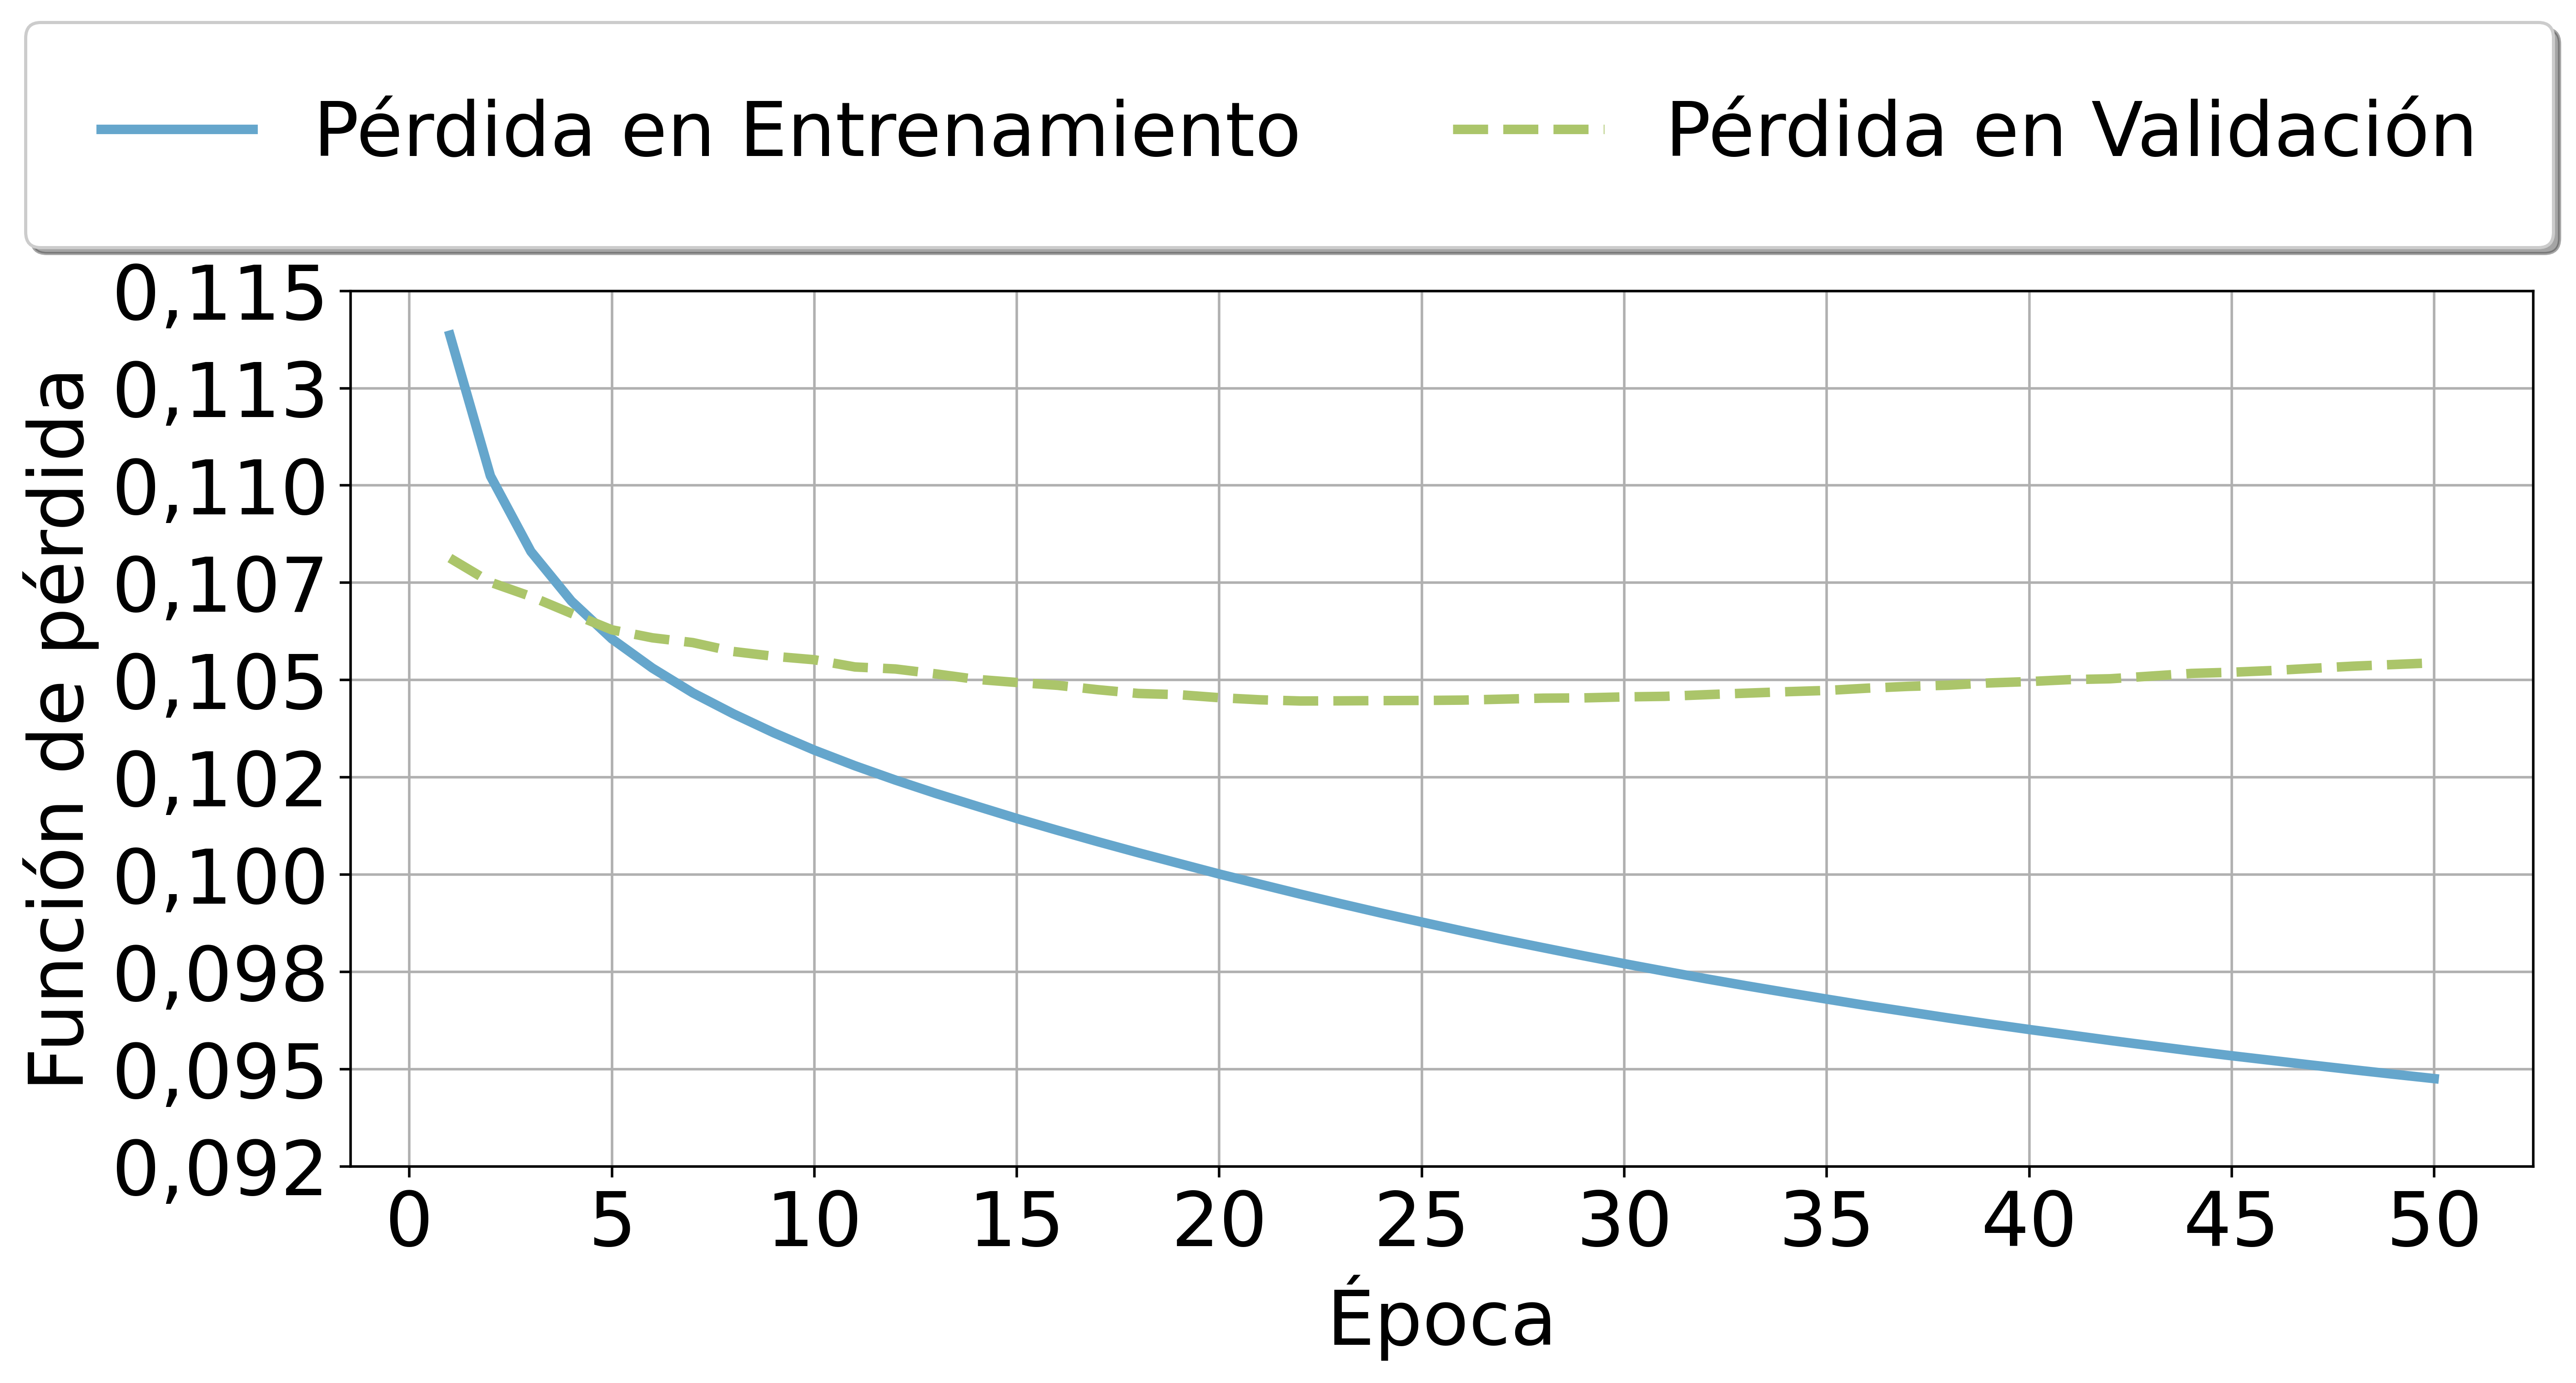

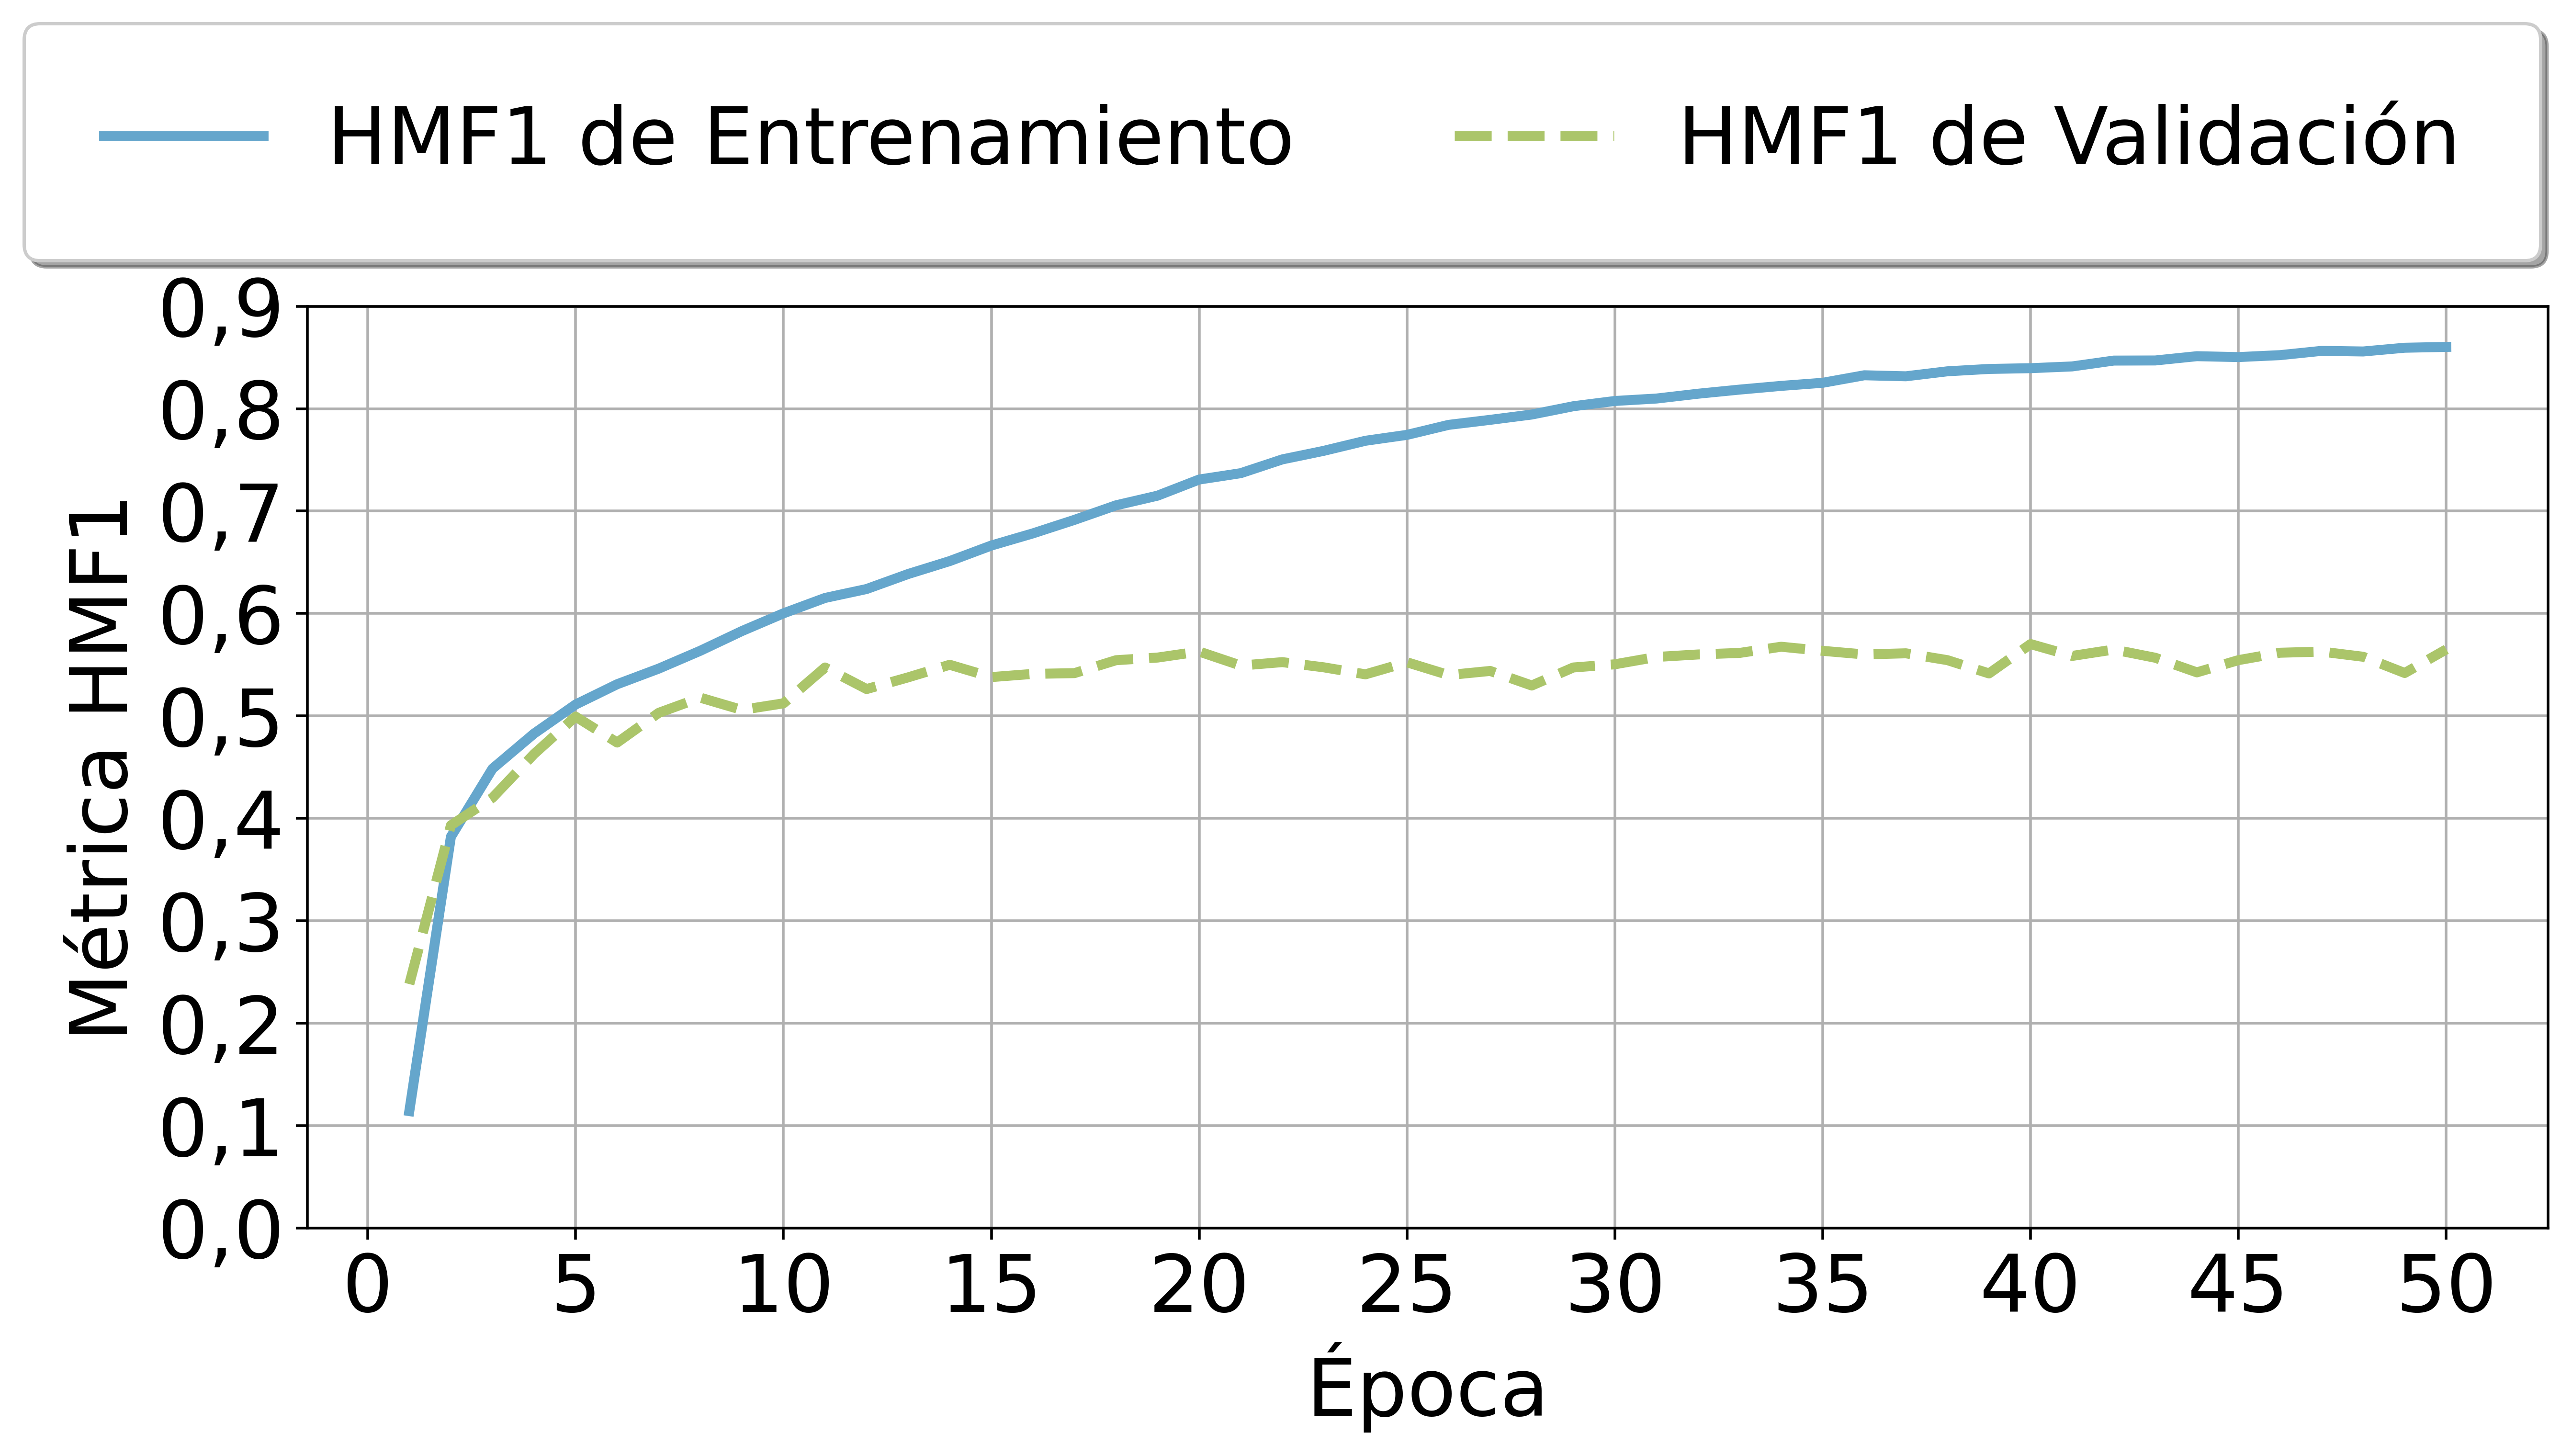

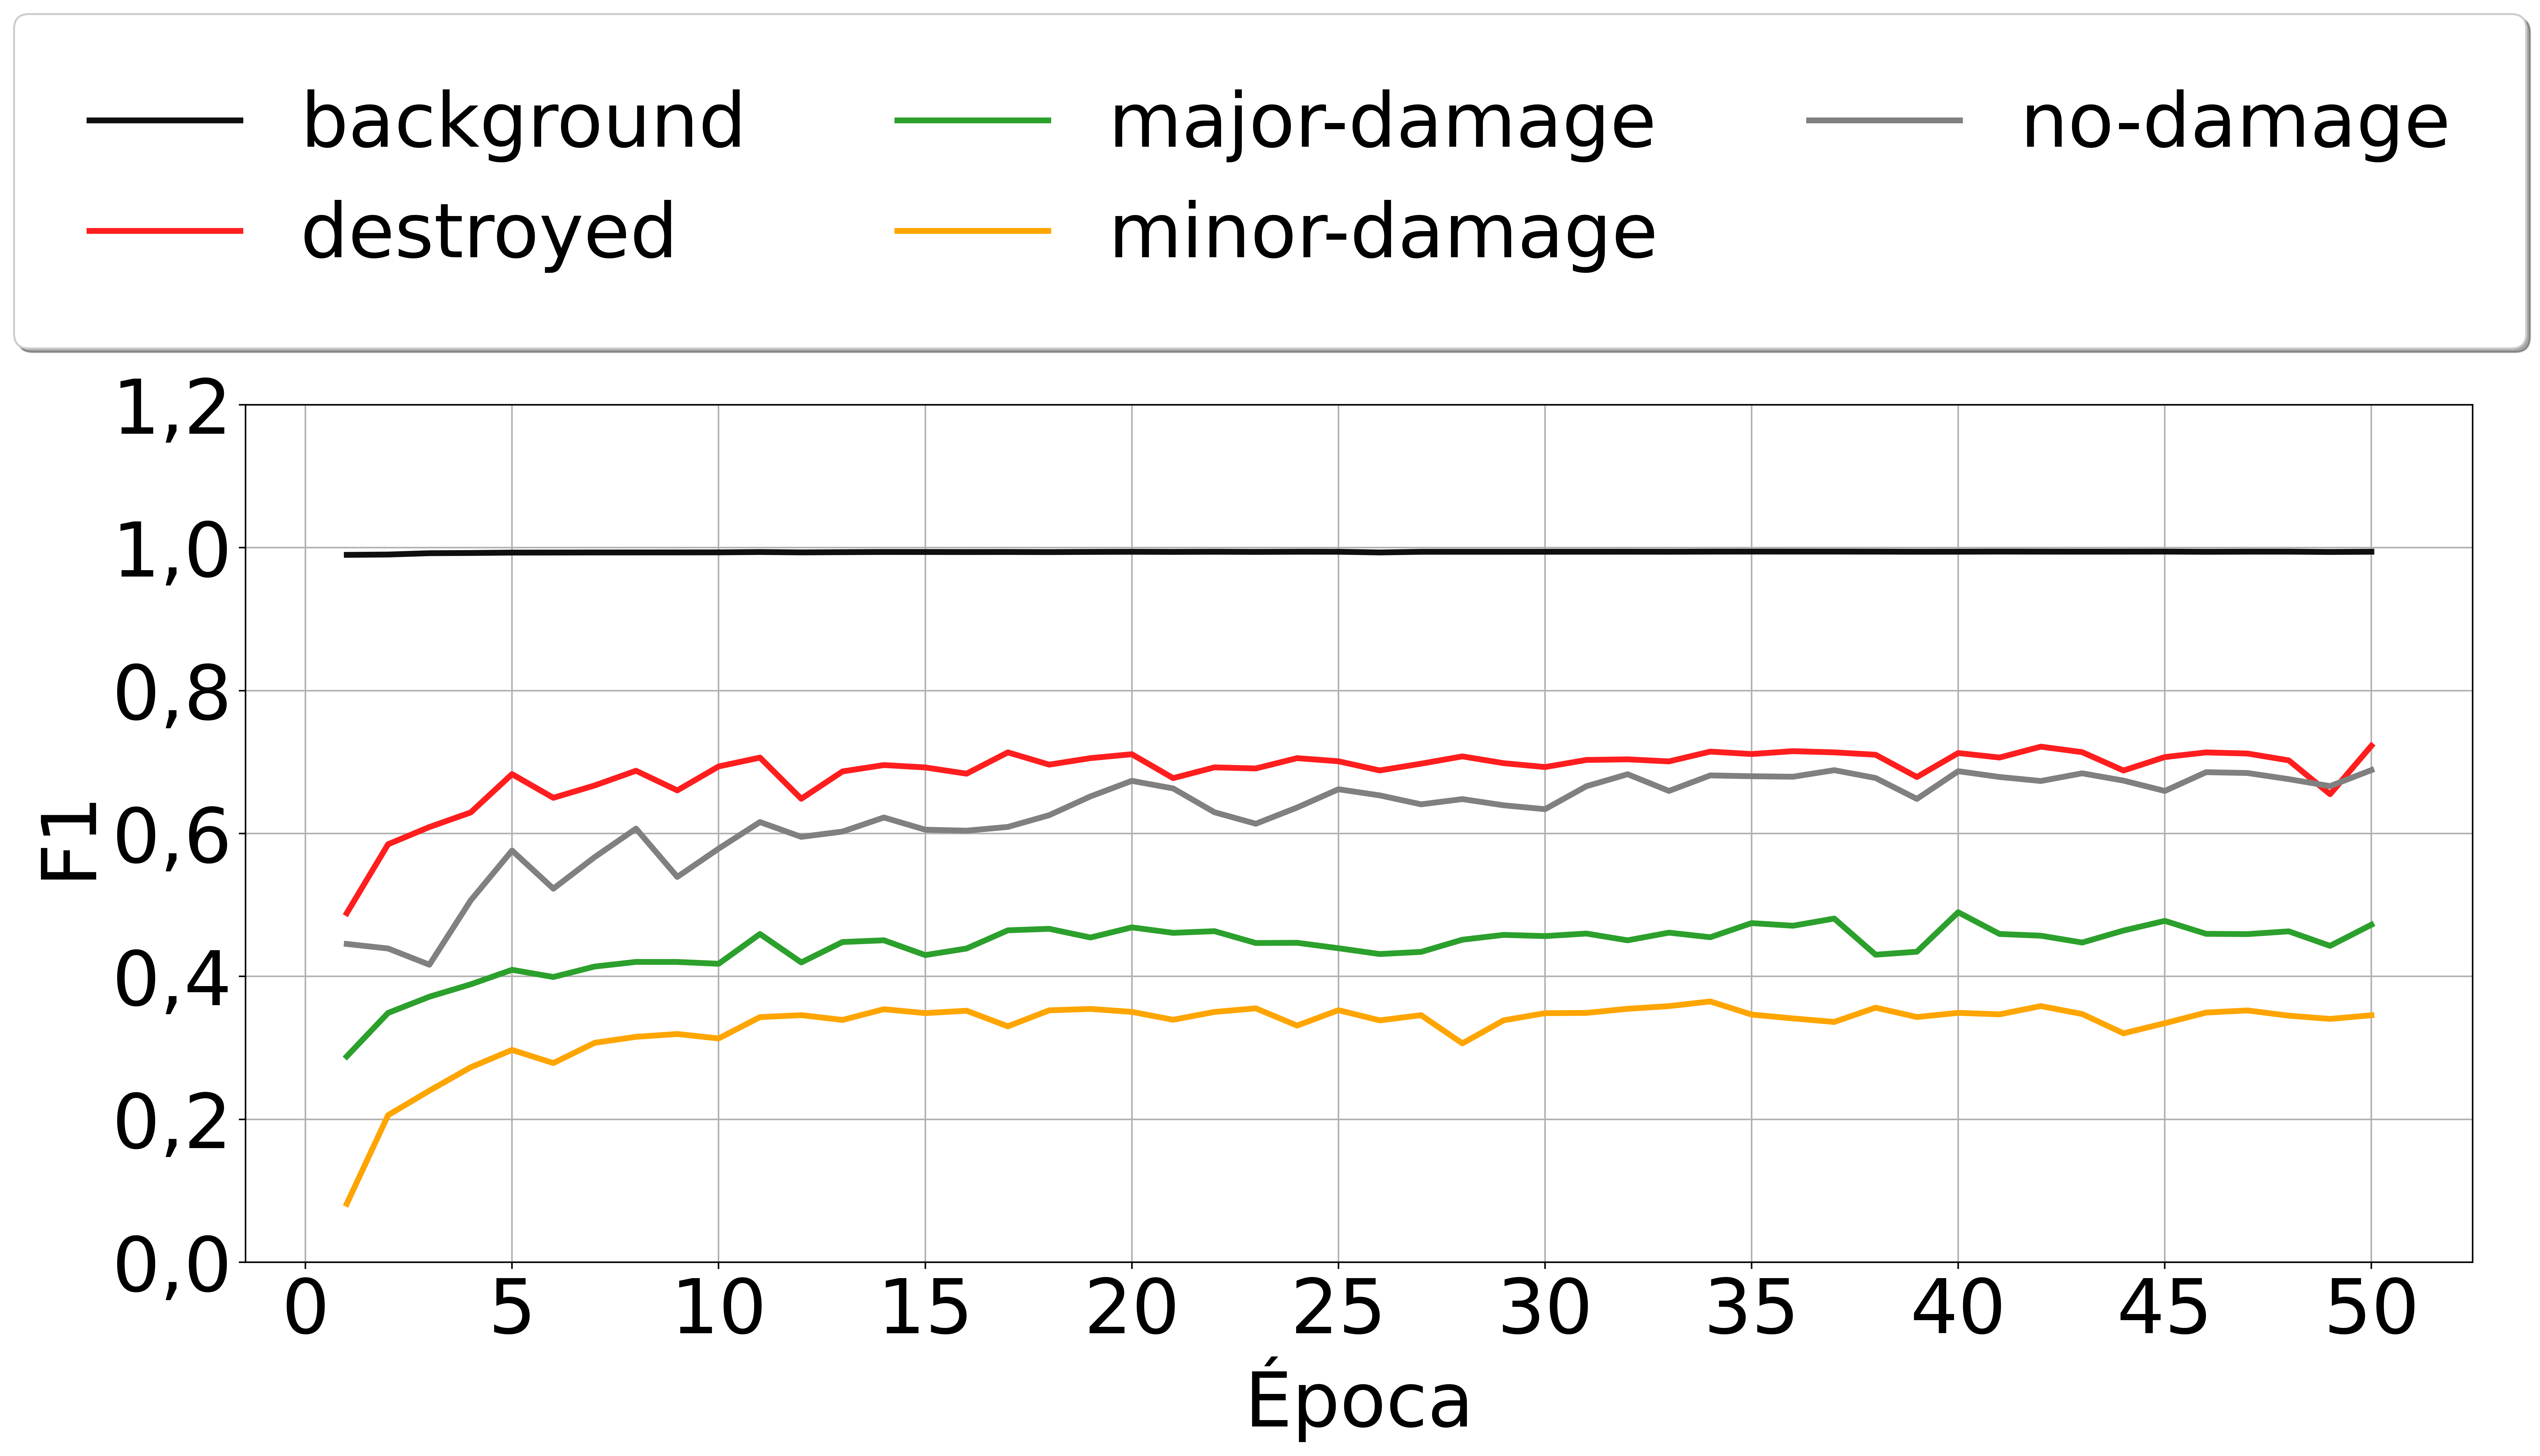

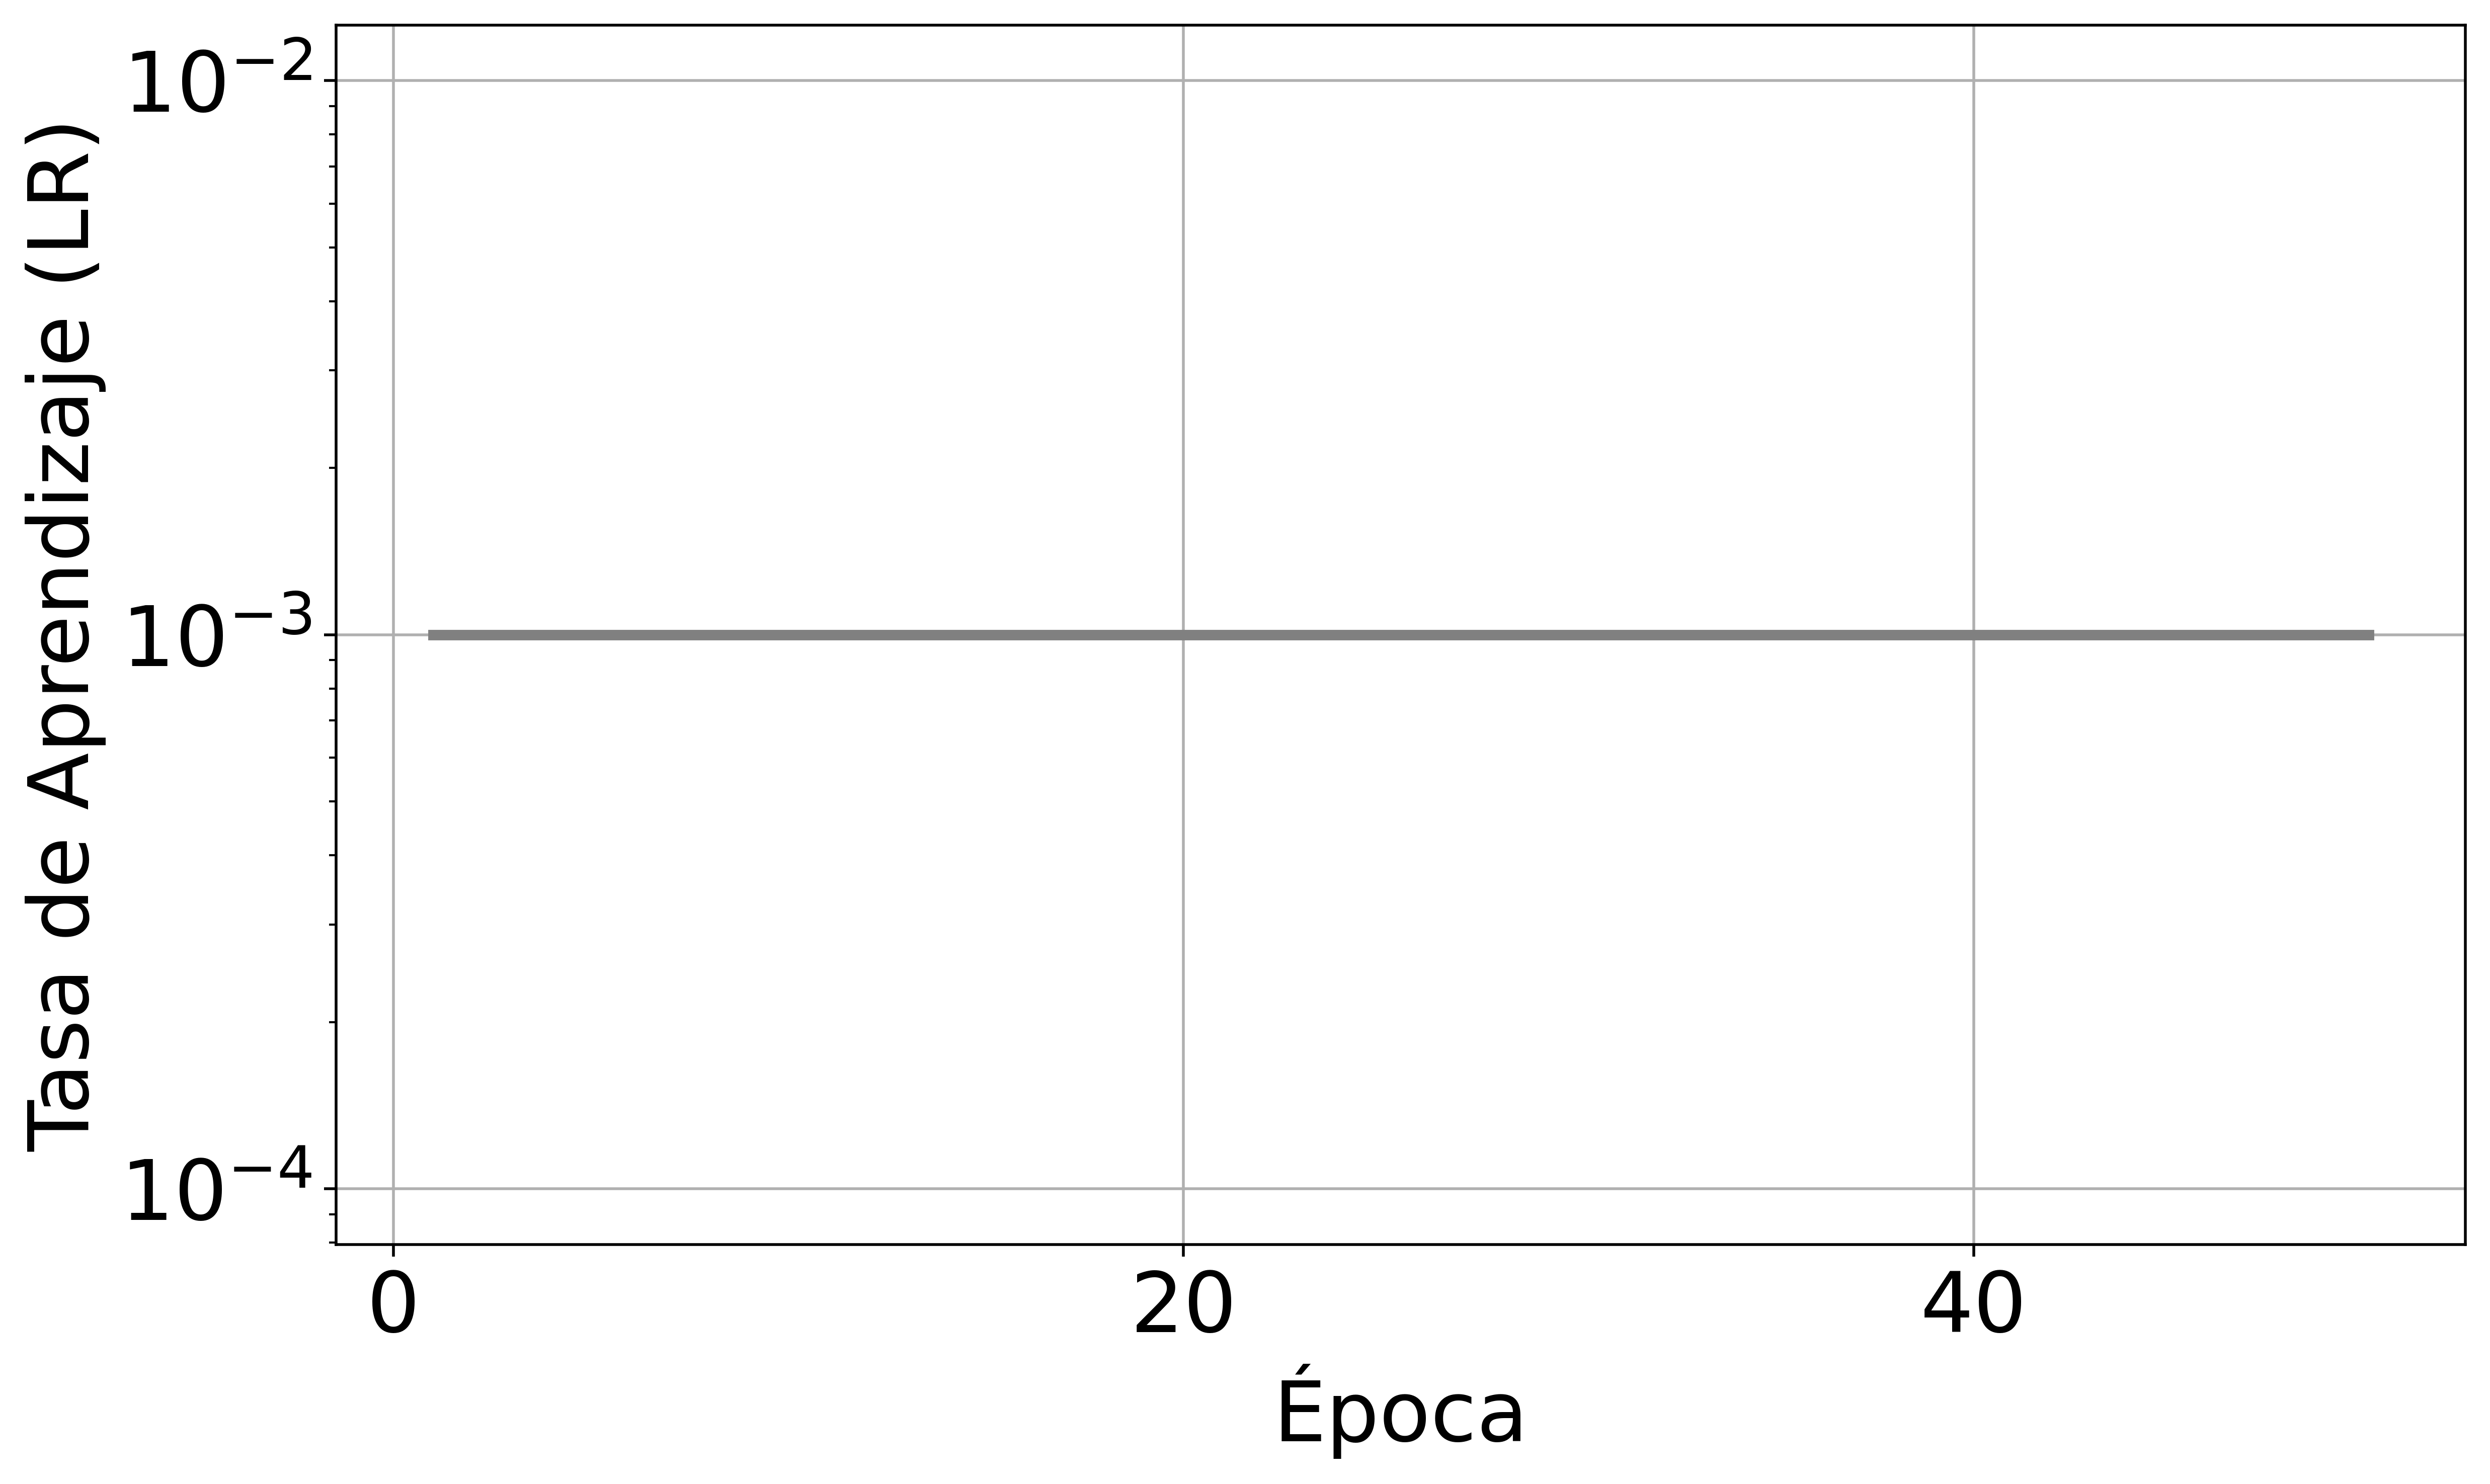

In [640]:
def_metric_dir = path.join("final_model/metrics/csv")

# loss_plots
loss_train_df = pd.read_csv(def_metric_dir.join("train_loss.csv"))
loss_train_df = loss_train_df.set_index("epoch")

loss_val_df = pd.read_csv(def_metric_dir.join("val_loss.csv"))
loss_val_df = loss_val_df.set_index("epoch")

plot_loss(loss_train_df, loss_val_df, 5)

dmg_train_df = pd.read_csv(def_metric_dir.join("train_dmg_pixel_level.csv"))
dmg_val_df = pd.read_csv(def_metric_dir.join("val_dmg_pixel_level.csv"))

plot_harmonic_mean(dmg_train_df, dmg_val_df, 5)

# val_f1_plots
dmg_val_df = pd.read_csv(def_metric_dir.join("val_dmg_pixel_level.csv"))
plot_metric_per_class(dmg_val_df, "f1", 5, loc='upper left')

lr_df = pd.read_csv(def_metric_dir.join("lr.csv"))
plot_lr(lr_df)

In [641]:
path = FilePath("/home/mrtc101/Desktop/tesina/repo/prev_outs/exp9/out")
p = path.join("postprocessing/metrics").join("pixel_multi_confusion_matrix.csv") 
mult_df = read_multi_csv(p)
mult_df

Background  No Damage  Minor Damage  Major Damage  Destroyed  \
Background     301937353     863486        246903        298431     279679   
No Damage        1420294    3845863        351150        360621      29936   
Minor Damage      409910     404750        505708        260759      24219   
Major Damage      322819     193731        187310        986386      84426   
Destroyed         304073      21062         16836         95788    1121307   
Total          304394449    5328892       1307907       2001985    1539567   

                  Total  
Background    303625852  
No Damage       6007864  
Minor Damage    1605346  
Major Damage    1774672  
Destroyed       1559066  
Total         314572800

In [642]:
bld_pixel_df = get_bld_px_multi(mult_df)
bld_pixel_df

Background  Building      Total
Background   301937353   1688499  303625852
Building       2457096   8489852   10946948
Total        304394449  10178351  314572800

In [643]:
bld_percentual_df = get_percentual_px_multi(bld_pixel_df)
bld_percentual_df

Background  Building      Total  Total%
Background        0.99      0.01  303625852    0.97
Building          0.22      0.78   10946948    0.03
Total             0.97      0.03  314572800    1.00

In [644]:
dmg_pixel_df = get_dmg_px_multi(mult_df)
dmg_pixel_df

No Damage  Minor Damage  Major Damage  Destroyed    Total
No Damage       3845863        351150        360621      29936  4587570
Minor Damage     404750        505708        260759      24219  1195436
Major Damage     193731        187310        986386      84426  1451853
Destroyed         21062         16836         95788    1121307  1254993
Total           4465406       1061004       1703554    1259888  8489852

In [645]:
get_percentual_px_multi(dmg_pixel_df)

No Damage  Minor Damage  Major Damage  Destroyed    Total  \
No Damage          0.84          0.08          0.08       0.01  4587570   
Minor Damage       0.34          0.42          0.22       0.02  1195436   
Major Damage       0.13          0.13          0.68       0.06  1451853   
Destroyed          0.02          0.01          0.08       0.89  1254993   
Total              0.53          0.12          0.20       0.15  8489852   

              Total%  
No Damage       0.54  
Minor Damage    0.14  
Major Damage    0.17  
Destroyed       0.15  
Total           1.00

### Object level performance

In [646]:
labels = ["No Damage", "Minor Damage", "Major Damage", "Destroyed", "Undetected","Total"]  
path = FilePath("/home/mrtc101/Desktop/tesina/repo/prev_outs/exp9/out")
p = path.join("postprocessing/metrics").join("obj_multi_confusion_matrix.csv") 
print(get_obj_mtrx(p).to_latex(float_format="%.4f"))

\begin{tabular}{lrrrrrr}
\toprule
 & No Damage & Minor Damage & Major Damage & Destroyed & Undetected & Total \\
\midrule
No Damage & 2048 & 226 & 102 & 32 & 1837 & 4245 \\
Minor Damage & 136 & 300 & 139 & 26 & 656 & 1257 \\
Major Damage & 73 & 118 & 462 & 59 & 568 & 1280 \\
Destroyed & 29 & 23 & 61 & 762 & 702 & 1577 \\
Ghost & 3128 & 804 & 869 & 1018 & 0 & 8359 \\
Total & 5414 & 1471 & 1633 & 1897 & 10415 & 0 \\
\bottomrule
\end{tabular}



In [647]:
path = FilePath("/home/mrtc101/Desktop/tesina/repo/prev_outs/exp9/out")
p = path.join("postprocessing/metrics").join("object_metrics.csv") 
print(get_obj_metrics(p).to_latex(float_format="%.4f"))

\begin{tabular}{lrrrrrr}
\toprule
 & f1_harmonic_mean & class & precision & recall & f1 & accuracy \\
\midrule
0 & 0.3242 & 1 & 0.3783 & 0.4824 & 0.4241 & 0.2691 \\
1 & 0.3242 & 2 & 0.2039 & 0.2387 & 0.2199 & 0.1236 \\
2 & 0.3242 & 3 & 0.2829 & 0.3609 & 0.3172 & 0.1885 \\
3 & 0.3242 & 4 & 0.4017 & 0.4832 & 0.4387 & 0.2810 \\
\bottomrule
\end{tabular}

